# AI Chef - Recipe Generator Chatbot
Natural Language Processing Coursework

Eoin Houstoun

Goldsmiths, University of London

<img src="AI_CHEF_ROBOT.png" alt="chef" width="450"/>

---

# 1. Introduction

This project presents the development of an **Intelligent Recipe Chatbot** designed to recommend meals based on natural language input describing user preferences. The system combines traditional and modern NLP techniques to understand queries such as _"a healthy high-protein dinner"_ or _"a quick vegetarian lunch"_ and return recipes that align closely with that intent.

1. **Data Scraping with BeautifulSoup**  
  Recipe data was extracted from the [BBC Good Food](https://www.bbcgoodfood.com/) website using `requests` and `BeautifulSoup`. Key fields collected include recipe titles, ingredients, cooking/prep times, servings, and instructions. The resulting structured dataset served as the foundation for text-based modelling.

2. **Data Preprocessing**
    - Combined relevant text fields (e.g., title + ingredients) into a single corpus for analysis.
    - Cleaned text by removing punctuation, converting to lowercase, and normalizing spacing.
    - Tokenized sentences into individual words using `nltk.word_tokenize`.
    - Removed stopwords to focus on meaningful content.
    - Applied stemming (`PorterStemmer`) and lemmatization (`WordNetLemmatizer`) to reduce words to their base forms.

3. **Exploratory Data Analysis (EDA)**
    - Generated a **word cloud** to visualize the most frequent terms across the recipe corpus.
    - Created **token count distribution histograms** to understand the variation in text length across recipes.
    - **Free-Text Recipe Search**  
  The chatbot interprets flexible, conversational input and returns recipes that best match the described intent, offering a natural and user-friendly discovery process.

4. **Baseline Model – Word Matching**  
  A simple word-matching approach was initially used, comparing tokens in user queries with recipe titles and ingredient lists. While functional, this baseline lacked semantic depth and struggled with synonyms or phrasing variations.

5. **TF-IDF with Cosine Similarity**  
  Text fields were vectorized using **TF-IDF**, and **cosine similarity** was computed between user queries and recipe documents. This approach improved relevance by considering term importance and overall context, allowing for more accurate recipe recommendations.

6. **DistilBERT for Contextual Understanding**  
  To incorporate contextual semantics, the project integrated **DistilBERT**, a distilled transformer-based language model. Embeddings generated from DistilBERT allowed for better semantic matching between queries and recipes, even when wording differed significantly.

7. **RecipeBERT Exploration**  
  Preliminary experimentation with **RecipeBERT** — a transformer model pre-trained on culinary data — highlighted its potential to further improve food-specific language understanding and enhance intent-driven recipe recommendations.

8. **PCA Visualisation**

This pipeline showcases how modern NLP techniques can be applied to domain-specific tasks, with an emphasis on semantic search, conversational understanding, and the integration of pretrained language models into intelligent interfaces.



![Workflow](workflow.png)


## 1.1 Import libraries

In [63]:
# ==========================
# NLP Libraries
# ==========================
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize, sent_tokenize   # Tokenization
from nltk.corpus import stopwords                        # Stopword removal
from nltk.stem import PorterStemmer, WordNetLemmatizer   # Stemming & Lemmatization

# ==========================
# General-Purpose Libraries
# ==========================
import pandas as pd
import numpy as np
import string
import ast
import time
from collections import Counter

# ==========================
# Visualization
# ==========================
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Enables 3D plots
from wordcloud import WordCloud          # Word frequency visualization

# ==========================
# Machine Learning & NLP Models
# ==========================
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

from transformers import DistilBertTokenizer, DistilBertModel
from transformers import AutoTokenizer, AutoModel
import torch

# ==========================
# Web Scraping
# ==========================
import requests
from bs4 import BeautifulSoup
import re

# ==========================
# Interactive Widgets
# ==========================
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.display import Markdown, display


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/eoinhoustoun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eoinhoustoun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/eoinhoustoun/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# 2. Scraping Data

## 2.1 Get Recipe Titles

In [ ]:
def scrape_titles(base_url):
    """
    Scrape BBC Good Food recipe titles from a URL.
    """
    recipes = []
    response = requests.get(base_url)
    if response.status_code != 200:
        print(f"Failed to fetch: {base_url}")
        return recipes

    # Parse the page content
    soup = BeautifulSoup(response.text, 'html.parser')

    # Extract meal titles
    meals = [item.text.strip() for item in soup.find_all('h2', class_='heading-4')]

    # Append titles to the recipe list
    recipes.extend(meals)
    return recipes


Used **BeautifulSoup** to systematically scrape and compile a comprehensive dataset of recipes from [BBC Good Food](https://www.bbcgoodfood.com/search?q=Quick+and+healthy+recipes&page=1).


In [ ]:
# list of URLs
base_urls = [
    f"https://www.bbcgoodfood.com/search?q=Quick+and+healthy+recipes&page={page}"
    for page in range(1, 334)  # Page 1 to 333 (10,00 Recipes)
]

all_recipes = []

for base_url in base_urls:
    page_recipes = scrape_titles(base_url)
    all_recipes.extend(page_recipes)

df_recipes = pd.DataFrame(all_recipes, columns=["Recipe Title"])
print(df_recipes)


                                           Recipe Title
0                                Quick seafood linguine
1                              Quick and easy fish stew
2                           Chicken & chorizo jambalaya
3                               Quick & easy flatbreads
4                                      Healthy pancakes
...                                                 ...
9985                          Smoky cheese & onion tart
9986  App onlyNiçoise focaccia sandwiches. This is a...
9987               The ultimate makeover: Chocolate log
9988  Clementine & vodka-baked salmon with beetroot ...
9989           Mushroom rarebit with mash & thyme gravy

[9990 rows x 1 columns]


Scraped 9,990 recipe titles

In [ ]:
# Convert the column to a single list
recipe_titles = df_recipes['Recipe Title'].explode().tolist()
formatted_titles = ",\n    ".join(f'"{title}"' for title in recipe_titles)
print(f"recipe_titles = [\n    {formatted_titles}\n]")


recipe_titles = [
    "Quick seafood linguine",
    "Quick and easy fish stew",
    "Chicken & chorizo jambalaya",
    "Quick & easy flatbreads",
    "Healthy pancakes",
    "Overnight oats",
    "Healthy tikka masala",
    "Healthy chicken katsu curry",
    "Quick chicken hummus bowl",
    "Healthy shakshuka",
    "Healthy pepper, tomato & ham omelette",
    "Chicken korma",
    "Chinese chicken curry",
    "Quick chicken curry",
    "Quick crumble mix",
    "Healthy turkey meatballs",
    "Healthy porridge bowl",
    "Healthy beef stew",
    "Quick pizza dough",
    "Healthy banana bread",
    "Healthy tomato soup",
    "Quick & easy chickpea coconut dhal",
    "Quick and easy pasta salad",
    "Quick prawn curry",
    "Healthy biscuits",
    "Easy lentil curry",
    "Pasta with salmon & peas",
    "Super-quick fish curry",
    "Quick chilli",
    "Quick prawn, coconut & tomato curry",
    "Healthy egg & chips",
    "Healthy chilli con carne",
    "Healthy fish pie",
    "Healthy bol

Function to slugify or change the titles to match the specific URL's


*   Remove Stop words
*   Make Lowercase
*   Remove Special Characters
*   Replace spaes with hyphens



In [ ]:
def slugify(title, stop_words=None):
    """
    Convert a title into a URL-friendly slug, removing stop words.
    """
    if stop_words is None:
        # Default list of common stop words
        stop_words = {'on', 'and', 'the', 'a', 'an', 'of', 'to', 'in', 'with'}

    title = title.lower()  # Convert to lowercase
    # Remove stop words
    title = ' '.join(word for word in title.split() if word not in stop_words)
    # Remove special characters
    title = re.sub(r'[^a-z0-9\s-]', '', title)
    # Replace spaces with hyphens
    title = re.sub(r'\s+', '-', title.strip())
    return title

## 2.2 Scrape Variables

Function to scrape specific information from recipes.

Scraping:

1.   Prep Time
2.   Cook Time
3.   Servings
4.   Ingredients
5.   Calories
5.   Fat
5.   Carbs
5.   Protein
5.   Instructions/Method







In [ ]:
def scrape_bbc_good_food(base_url, recipe_titles):
    """
    Scrape BBC Good Food recipes using constructed URLs.
    """
    recipes = []

    for title in recipe_titles:
        try:
            # Construct the full recipe URL
            slug = slugify(title)
            recipe_url = f"{base_url}{slug}"

            # Fetch the recipe page
            response = requests.get(recipe_url)
            if response.status_code != 200:
                print(f"Failed to fetch: {recipe_url}")
                continue

            # Parse the page content
            soup = BeautifulSoup(response.text, 'html.parser')

            # Initialize variables with default values
            prep_time, cook_time, servings = None, None, None
            calories, fat, carbs, protein = None, None, None, None

            try:
                prep_time = [item.text.strip() for item in soup.find_all('li', class_='body-copy-small list-item')]
            except Exception:
                print(f"Prep time not found for: {title}")

            try:
                cook_time = [item.text.strip() for item in soup.find_all('li', class_='body-copy-small list-item')]
            except Exception:
                print(f"Cook time not found for: {title}")

            try:
                servings = [item.text.strip() for item in soup.find_all('li', class_='mt-sm list-item')]
            except Exception:
                print(f"Servings not found for: {title}")

            try:
                ingredients = [item.text.strip() for item in soup.find_all('li', class_='ingredients-list__item')]
            except Exception:
                print(f"Ingredients not found for: {title}")
                ingredients = []

            try:
                calories_text = soup.select_one('ul.nutrition-list > li.nutrition-list__item:nth-of-type(1)').text.strip()
                calories = ''.join(filter(str.isdigit, calories_text))
            except Exception:
                print(f"Calories not found for: {title}")

            try:
                fat_text = soup.select_one('ul.nutrition-list > li.nutrition-list__item:nth-of-type(2)').text.strip()
                fat = ''.join(filter(str.isdigit, fat_text))
            except Exception:
                print(f"Fat not found for: {title}")

            try:
                carbs_text = soup.select_one('ul.nutrition-list > li.nutrition-list__item:nth-of-type(4)').text.strip()
                carbs = ''.join(filter(str.isdigit, carbs_text))
            except Exception:
                print(f"Carbs not found for: {title}")

            try:
                protein_text = soup.select_one('ul.nutrition-list > li.nutrition-list__item:nth-of-type(7)').text.strip()
                protein = ''.join(filter(str.isdigit, protein_text))
            except Exception:
                print(f"Protein not found for: {title}")

            try:
                method_steps = [step.find('p').text.strip() for step in soup.find_all('li', class_='method-steps__list-item')]
                method = " ".join(method_steps)
            except Exception:
                print(f"Method not found for: {title}")
                method = ""

            # Append to the recipe list
            recipes.append({
                'Title': title,
                'Prep Time (mins)': prep_time,
                'Cook Time (mins)': cook_time,
                'Servings': servings,
                'Ingredients': ", ".join(ingredients),
                'Method': method,
                'Calories (g)': calories,
                'Fat (g)': fat,
                'Carbs (g)': carbs,
                'Protein (g)': protein
            })

        except Exception as e:
            print(f"Error processing recipe '{title}': {e}")
            continue

    return recipes


Scraped detailed information from 10,000 recipes, taking around 2 hours and 15 minutes to complete. Error handling was included so that if a recipe was missing certain information, the scraper would simply skip it and move on. Additionally, sometimes minor differences in the URL caused mismatches; in these cases, the scraper clearly displayed 'Failed to Fetch:' along with the problematic URL

In [ ]:
base_url = "https://www.bbcgoodfood.com/recipes/"

# Scrape the data
recipe_data = scrape_bbc_good_food(base_url, recipe_titles)

if recipe_data:
    df = pd.DataFrame(recipe_data)
    df.to_csv("bbc_good_food_recipes.csv", index=False)

    print("Scraping completed. Data saved to 'bbc_good_food_recipes.csv'.")

Failed to fetch: https://www.bbcgoodfood.com/recipes/quick-seafood-linguine
Failed to fetch: https://www.bbcgoodfood.com/recipes/quick-easy-fish-stew
Failed to fetch: https://www.bbcgoodfood.com/recipes/quick-easy-flatbreads
Failed to fetch: https://www.bbcgoodfood.com/recipes/healthy-chicken-katsu-curry
Failed to fetch: https://www.bbcgoodfood.com/recipes/healthy-pepper-tomato-ham-omelette
Failed to fetch: https://www.bbcgoodfood.com/recipes/quick-chicken-curry
Failed to fetch: https://www.bbcgoodfood.com/recipes/healthy-turkey-meatballs
Failed to fetch: https://www.bbcgoodfood.com/recipes/healthy-beef-stew
Failed to fetch: https://www.bbcgoodfood.com/recipes/quick-easy-pasta-salad
Failed to fetch: https://www.bbcgoodfood.com/recipes/quick-prawn-curry
Failed to fetch: https://www.bbcgoodfood.com/recipes/healthy-biscuits
Failed to fetch: https://www.bbcgoodfood.com/recipes/easy-lentil-curry
Calories not found for: Healthy chilli con carne
Fat not found for: Healthy chilli con carne
Car

# 3. Preprocessing - After Scraping

Load in dataset

In [4]:
recipe_path = "/Users/eoinhoustoun/Desktop/Goldsmiths/Semester 2/Natural Language Processing/CW1/bbc_good_food_recipes.csv"
recipe_df = pd.read_csv(recipe_path)

## 3.1 Dealing with Missingness

In [5]:
recipe_df.head()

,Title,Prep Time (mins),Cook Time (mins),Servings,Ingredients,Method,Calories (g),Fat (g),Carbs (g),Protein (g)
0,Chicken & chorizo jambalaya,"['Prep:10 mins', 'Cook:45 mins']","['Prep:10 mins', 'Cook:45 mins']",['Serves 4'],"1 tbsp olive oil, 2 chicken breasts chopped, 1...",Heat 1 tbsp olive oil in a large frying pan wi...,445.0,10.0,64.0,30.0
1,Healthy pancakes,"['Prep:15 mins', 'Cook:30 mins']","['Prep:15 mins', 'Cook:30 mins']",['Makes 10-12'],"50g self-raising flour, 50g wholemeal or whole...",Sift the flours into a bowl or wide jug and ti...,53.0,1.0,8.0,3.0
2,Overnight oats,['Prep:10 mins'],['Prep:10 mins'],['Serves 1'],"¼ tsp ground cinnamon, 50g rolled porridge oa...","The night before serving, stir the cinnamon an...",348.0,11.0,4607.0,13.0
3,Healthy tikka masala,"['Prep:10 mins', 'Cook:55 mins']","['Prep:10 mins', 'Cook:55 mins']",['Serves 4'],"1 large onion chopped, 4 large garlic cloves, ...","Put the onion, garlic and ginger in a food pro...",365.0,17.0,13.0,38.0
4,Quick chicken hummus bowl,['Prep:10 mins'],['Prep:10 mins'],['Serves 2'],"200g hummus, 1 small lemon zested and juiced,...",Mix 2 tbsp of the hummus with half the lemon j...,779.0,47.0,49.0,34.0


In [6]:
recipe_df.describe()

,Calories (g),Fat (g),Carbs (g),Protein (g)
count,8071.000000,8071.000000,8067.000000,8067.000000
mean,386.787635,22.524718,44.018470,21.084294
std,375.006878,67.839236,222.266376,68.409796
min,0.000000,0.000000,0.000000,0.000000
25%,225.000000,8.000000,14.000000,5.000000
50%,373.000000,16.000000,31.000000,15.000000
75%,520.000000,27.000000,50.000000,29.000000
max,28201.000000,3003.000000,12107.000000,4637.000000


In [7]:
missing_summary = recipe_df.isnull().sum()
print(missing_summary)


Title                 0
Prep Time (mins)      0
Cook Time (mins)      0
Servings              0
Ingredients         370
Method              376
Calories (g)        409
Fat (g)             409
Carbs (g)           413
Protein (g)         413
dtype: int64


In [8]:
recipe_df = recipe_df.dropna()

print(recipe_df.isnull().sum())  # Should print all zeros if no missing values remain
print(f"Remaining rows: {len(recipe_df)}")  # Check how many rows are left

Title               0
Prep Time (mins)    0
Cook Time (mins)    0
Servings            0
Ingredients         0
Method              0
Calories (g)        0
Fat (g)             0
Carbs (g)           0
Protein (g)         0
dtype: int64
Remaining rows: 8064


In [9]:
def extract_total_time(prep_time_str):
    """
    Extracts the total time (minutes) from a string that contains 'Total time'.
    """
    match = re.search(r'Total time(\d+)', prep_time_str)  # Find 'Total time' followed by a number
    return int(match.group(1)) if match else None  # Convert to integer if found, else None

# Apply function to extract 'Total time' values into a new column
recipe_df["Total Time (mins)"] = recipe_df["Prep Time (mins)"].astype(str).apply(extract_total_time)

# Display the updated DataFrame
print(recipe_df[["Prep Time (mins)", "Total Time (mins)"]].head())


                   Prep Time (mins)  Total Time (mins)
0  ['Prep:10 mins', 'Cook:45 mins']                NaN
1  ['Prep:15 mins', 'Cook:30 mins']                NaN
2                  ['Prep:10 mins']                NaN
3  ['Prep:10 mins', 'Cook:55 mins']                NaN
4                  ['Prep:10 mins']                NaN


In [10]:
recipe_df

,Title,Prep Time (mins),Cook Time (mins),Servings,Ingredients,Method,Calories (g),Fat (g),Carbs (g),Protein (g),Total Time (mins)
0,Chicken & chorizo jambalaya,"['Prep:10 mins', 'Cook:45 mins']","['Prep:10 mins', 'Cook:45 mins']",['Serves 4'],"1 tbsp olive oil, 2 chicken breasts chopped, 1...",Heat 1 tbsp olive oil in a large frying pan wi...,445.0,10.0,64.0,30.0,NaN
1,Healthy pancakes,"['Prep:15 mins', 'Cook:30 mins']","['Prep:15 mins', 'Cook:30 mins']",['Makes 10-12'],"50g self-raising flour, 50g wholemeal or whole...",Sift the flours into a bowl or wide jug and ti...,53.0,1.0,8.0,3.0,NaN
2,Overnight oats,['Prep:10 mins'],['Prep:10 mins'],['Serves 1'],"¼ tsp ground cinnamon, 50g rolled porridge oa...","The night before serving, stir the cinnamon an...",348.0,11.0,4607.0,13.0,NaN
3,Healthy tikka masala,"['Prep:10 mins', 'Cook:55 mins']","['Prep:10 mins', 'Cook:55 mins']",['Serves 4'],"1 large onion chopped, 4 large garlic cloves, ...","Put the onion, garlic and ginger in a food pro...",365.0,17.0,13.0,38.0,NaN
4,Quick chicken hummus bowl,['Prep:10 mins'],['Prep:10 mins'],['Serves 2'],"200g hummus, 1 small lemon zested and juiced,...",Mix 2 tbsp of the hummus with half the lemon j...,779.0,47.0,49.0,34.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
8474,Thai salmon kebabs with sweet chilli & lime dip,['Total time30 mins'],['Total time30 mins'],['Serves 4'],"4 tbsp sweet chilli sauce, juice 1 lime, 4 x...",Combine the sweet chilli sauce and lime juice ...,291.0,19.0,3.0,29.0,30.0
8475,Oxtail stew,"['Prep:20 mins', 'Cook:3 hrs and 30 mins']","['Prep:20 mins', 'Cook:3 hrs and 30 mins']",['Serves 6'],"2 tbsp plain flour, 2 (about 3kg) oxtail joint...",Heat oven to 180C/fan 160C/gas 4. Season the f...,812.0,41.0,50.0,53.0,NaN
8476,Smoked haddock tartlets with poached eggs,"['Prep:40 mins', 'Cook:1 hr']","['Prep:40 mins', 'Cook:1 hr']",['Serves 4'],"500g block all-butter shortcrust pastry, 400g...",Heat oven to 200C/180C fan/ gas 6. Divide the ...,1048.0,70.0,60.0,48.0,NaN
8477,Bread & butter pudding toast,"['Prep:25 mins', 'Cook:20 mins']","['Prep:25 mins', 'Cook:20 mins']",['Serves 4'],"400g brioche loaf, 3 eggs, 120g whole milk, 75...",Use a bread knife to remove the crusts and squ...,943.0,63.0,75.0,15.0,NaN


In [12]:
# Function to extract the prep time
def extract_prep_time(prep_time_str):
    match = re.search(r'Prep:(\d+)', prep_time_str)
    return int(match.group(1)) if match else None  # Convert to integer if found

# Apply function to the column
recipe_df["Prep Time (mins)"] = recipe_df["Prep Time (mins)"].apply(lambda x: extract_prep_time(str(x)))

# Display the updated DataFrame
print(recipe_df[["Prep Time (mins)"]].head())


def extract_cook_time(cook_time_str):
    match = re.search(r'Cook:(\d+)', cook_time_str)
    return int(match.group(1)) if match else None  # Convert to integer if found

# Apply function to the column
recipe_df["Cook Time (mins)"] = recipe_df["Cook Time (mins)"].apply(lambda x: extract_cook_time(str(x)))

# Display the updated DataFrame
print(recipe_df[["Cook Time (mins)"]].head())



   Prep Time (mins)
0              10.0
1              15.0
2              10.0
3              10.0
4              10.0
   Cook Time (mins)
0              45.0
1              30.0
2               NaN
3              55.0
4               NaN


Separated preparation time and cooking time into distinct variables for clearer analysis and easier manipulation.

In [13]:
recipe_df.head()

,Title,Prep Time (mins),Cook Time (mins),Servings,Ingredients,Method,Calories (g),Fat (g),Carbs (g),Protein (g),Total Time (mins)
0,Chicken & chorizo jambalaya,10.0,45.0,['Serves 4'],"1 tbsp olive oil, 2 chicken breasts chopped, 1...",Heat 1 tbsp olive oil in a large frying pan wi...,445.0,10.0,64.0,30.0,NaN
1,Healthy pancakes,15.0,30.0,['Makes 10-12'],"50g self-raising flour, 50g wholemeal or whole...",Sift the flours into a bowl or wide jug and ti...,53.0,1.0,8.0,3.0,NaN
2,Overnight oats,10.0,NaN,['Serves 1'],"¼ tsp ground cinnamon, 50g rolled porridge oa...","The night before serving, stir the cinnamon an...",348.0,11.0,4607.0,13.0,NaN
3,Healthy tikka masala,10.0,55.0,['Serves 4'],"1 large onion chopped, 4 large garlic cloves, ...","Put the onion, garlic and ginger in a food pro...",365.0,17.0,13.0,38.0,NaN
4,Quick chicken hummus bowl,10.0,NaN,['Serves 2'],"200g hummus, 1 small lemon zested and juiced,...",Mix 2 tbsp of the hummus with half the lemon j...,779.0,47.0,49.0,34.0,NaN


In [14]:
print(recipe_df.isnull().sum())
print(f"Remaining rows: {len(recipe_df)}")

Title                   0
Prep Time (mins)      343
Cook Time (mins)     1133
Servings                0
Ingredients             0
Method                  0
Calories (g)            0
Fat (g)                 0
Carbs (g)               0
Protein (g)             0
Total Time (mins)    7818
dtype: int64
Remaining rows: 8064


Preparation times were set to 0 minutes when no preparation was required. Similarly, certain recipes didn't require cooking; in these cases, cooking times were also correctly recorded as 0 minutes. These zeros indicate genuine 'no-prep' or 'no-cook' scenarios rather than missing data.

In [15]:
recipe_df.fillna(0, inplace=True)
print(recipe_df.isnull().sum())

Title                0
Prep Time (mins)     0
Cook Time (mins)     0
Servings             0
Ingredients          0
Method               0
Calories (g)         0
Fat (g)              0
Carbs (g)            0
Protein (g)          0
Total Time (mins)    0
dtype: int64


In [16]:
# If 'Total Time (mins)' is 0, replace it with Prep + Cook times
recipe_df["Total Time (mins)"] = recipe_df.apply(
    lambda row: row["Prep Time (mins)"] + row["Cook Time (mins)"] if row["Total Time (mins)"] == 0 else row["Total Time (mins)"],
    axis=1
)
print(recipe_df[["Prep Time (mins)", "Cook Time (mins)", "Total Time (mins)"]].head())


   Prep Time (mins)  Cook Time (mins)  Total Time (mins)
0              10.0              45.0               55.0
1              15.0              30.0               45.0
2              10.0               0.0               10.0
3              10.0              55.0               65.0
4              10.0               0.0               10.0


In [17]:
# recipe_df.to_csv("bbc_good_food_recipes_preprocessed.csv", index=False)

Saved the dataset after preprocessing

In [18]:
recipe_path = "/Users/eoinhoustoun/Desktop/Goldsmiths/Semester 2/Natural Language Processing/CW1/bbc_good_food_recipes_preprocessed.csv"
recipe_df = pd.read_csv(recipe_path)

In [19]:
recipe_df

,Title,Prep Time (mins),Cook Time (mins),Servings,Ingredients,Method,Calories (g),Fat (g),Carbs (g),Protein (g),Total Time (mins)
0,Chicken & chorizo jambalaya,10.0,45.0,['Serves 4'],"1 tbsp olive oil, 2 chicken breasts chopped, 1...",Heat 1 tbsp olive oil in a large frying pan wi...,445.0,10.0,64.0,30.0,55.0
1,Healthy pancakes,15.0,30.0,['Makes 10-12'],"50g self-raising flour, 50g wholemeal or whole...",Sift the flours into a bowl or wide jug and ti...,53.0,1.0,8.0,3.0,45.0
2,Overnight oats,10.0,0.0,['Serves 1'],"¼ tsp ground cinnamon, 50g rolled porridge oa...","The night before serving, stir the cinnamon an...",348.0,11.0,4607.0,13.0,10.0
3,Healthy tikka masala,10.0,55.0,['Serves 4'],"1 large onion chopped, 4 large garlic cloves, ...","Put the onion, garlic and ginger in a food pro...",365.0,17.0,13.0,38.0,65.0
4,Quick chicken hummus bowl,10.0,0.0,['Serves 2'],"200g hummus, 1 small lemon zested and juiced,...",Mix 2 tbsp of the hummus with half the lemon j...,779.0,47.0,49.0,34.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...
8059,Thai salmon kebabs with sweet chilli & lime dip,0.0,0.0,['Serves 4'],"4 tbsp sweet chilli sauce, juice 1 lime, 4 x...",Combine the sweet chilli sauce and lime juice ...,291.0,19.0,3.0,29.0,30.0
8060,Oxtail stew,20.0,3.0,['Serves 6'],"2 tbsp plain flour, 2 (about 3kg) oxtail joint...",Heat oven to 180C/fan 160C/gas 4. Season the f...,812.0,41.0,50.0,53.0,23.0
8061,Smoked haddock tartlets with poached eggs,40.0,1.0,['Serves 4'],"500g block all-butter shortcrust pastry, 400g...",Heat oven to 200C/180C fan/ gas 6. Divide the ...,1048.0,70.0,60.0,48.0,41.0
8062,Bread & butter pudding toast,25.0,20.0,['Serves 4'],"400g brioche loaf, 3 eggs, 120g whole milk, 75...",Use a bread knife to remove the crusts and squ...,943.0,63.0,75.0,15.0,45.0


## 3.2 Combine text

In [22]:
# Combine Title, Ingredients, and Method into one searchable text field
recipe_df["Searchable_Text"] = (
    recipe_df["Title"] + " " +
    recipe_df["Ingredients"].apply(lambda x: " ".join(x) if isinstance(x, list) else x) + " " +
    recipe_df["Method"]
)


In [21]:
recipe_df

,Title,Prep Time (mins),Cook Time (mins),Servings,Ingredients,Method,Calories (g),Fat (g),Carbs (g),Protein (g),Total Time (mins),Searchable_Text
0,Chicken & chorizo jambalaya,10.0,45.0,['Serves 4'],"1 tbsp olive oil, 2 chicken breasts chopped, 1...",Heat 1 tbsp olive oil in a large frying pan wi...,445.0,10.0,64.0,30.0,55.0,"Chicken & chorizo jambalaya 1 tbsp olive oil, ..."
1,Healthy pancakes,15.0,30.0,['Makes 10-12'],"50g self-raising flour, 50g wholemeal or whole...",Sift the flours into a bowl or wide jug and ti...,53.0,1.0,8.0,3.0,45.0,"Healthy pancakes 50g self-raising flour, 50g w..."
2,Overnight oats,10.0,0.0,['Serves 1'],"¼ tsp ground cinnamon, 50g rolled porridge oa...","The night before serving, stir the cinnamon an...",348.0,11.0,4607.0,13.0,10.0,"Overnight oats ¼ tsp ground cinnamon, 50g rol..."
3,Healthy tikka masala,10.0,55.0,['Serves 4'],"1 large onion chopped, 4 large garlic cloves, ...","Put the onion, garlic and ginger in a food pro...",365.0,17.0,13.0,38.0,65.0,"Healthy tikka masala 1 large onion chopped, 4 ..."
4,Quick chicken hummus bowl,10.0,0.0,['Serves 2'],"200g hummus, 1 small lemon zested and juiced,...",Mix 2 tbsp of the hummus with half the lemon j...,779.0,47.0,49.0,34.0,10.0,"Quick chicken hummus bowl 200g hummus, 1 small..."
...,...,...,...,...,...,...,...,...,...,...,...,...
8059,Thai salmon kebabs with sweet chilli & lime dip,0.0,0.0,['Serves 4'],"4 tbsp sweet chilli sauce, juice 1 lime, 4 x...",Combine the sweet chilli sauce and lime juice ...,291.0,19.0,3.0,29.0,30.0,Thai salmon kebabs with sweet chilli & lime di...
8060,Oxtail stew,20.0,3.0,['Serves 6'],"2 tbsp plain flour, 2 (about 3kg) oxtail joint...",Heat oven to 180C/fan 160C/gas 4. Season the f...,812.0,41.0,50.0,53.0,23.0,"Oxtail stew 2 tbsp plain flour, 2 (about 3kg) ..."
8061,Smoked haddock tartlets with poached eggs,40.0,1.0,['Serves 4'],"500g block all-butter shortcrust pastry, 400g...",Heat oven to 200C/180C fan/ gas 6. Divide the ...,1048.0,70.0,60.0,48.0,41.0,Smoked haddock tartlets with poached eggs 500g...
8062,Bread & butter pudding toast,25.0,20.0,['Serves 4'],"400g brioche loaf, 3 eggs, 120g whole milk, 75...",Use a bread knife to remove the crusts and squ...,943.0,63.0,75.0,15.0,45.0,Bread & butter pudding toast 400g brioche loaf...


## 3.2 Data Cleaning


In [25]:
data = recipe_df

# Normalize text (lowercase, remove URLs, special characters, and numbers)
# Note: Regular expressions (regex) are a powerful tool for pattern matching in text. In regex:
# - \S matches any non-whitespace character.
# - \d matches digits, and \W matches non-word characters.
# - | is used as OR to combine multiple patterns.

def clean_text(text):
 text = text.lower()
 text = re.sub(r"http\S+|www\S+|https\S+", '', text)
 text = re.sub(r"\W+|\d+", ' ', text)
 return text

data['cleaned_text'] = data["Searchable_Text"].apply(clean_text)
print(data['cleaned_text'].head())

0    chicken chorizo jambalaya   tbsp olive oil   c...
1    healthy pancakes  g self raising flour  g whol...
2    overnight oats ¼ tsp ground cinnamon  g rolled...
3    healthy tikka masala   large onion chopped   l...
4    quick chicken hummus bowl  g hummus   small le...
Name: cleaned_text, dtype: object


## 3.3 Tokenization


In [26]:
# Word Tokenization
data['tokens'] = data['cleaned_text'].apply(word_tokenize)
print(data['tokens'].head())
# Sentence Tokenization (Optional)
data['sentences'] = data['cleaned_text'].apply(sent_tokenize)
print(data['sentences'].head())

0    [chicken, chorizo, jambalaya, tbsp, olive, oil...
1    [healthy, pancakes, g, self, raising, flour, g...
2    [overnight, oats, ¼, tsp, ground, cinnamon, g,...
3    [healthy, tikka, masala, large, onion, chopped...
4    [quick, chicken, hummus, bowl, g, hummus, smal...
Name: tokens, dtype: object
0    [chicken chorizo jambalaya   tbsp olive oil   ...
1    [healthy pancakes  g self raising flour  g who...
2    [overnight oats ¼ tsp ground cinnamon  g rolle...
3    [healthy tikka masala   large onion chopped   ...
4    [quick chicken hummus bowl  g hummus   small l...
Name: sentences, dtype: object


## 3.4 Stopword Removal


In [27]:
stop_words = set(stopwords.words('english'))
data['filtered_tokens'] = data['tokens'].apply(lambda x: [word for word in x if word not in stop_words])
print(data['filtered_tokens'].head())

0    [chicken, chorizo, jambalaya, tbsp, olive, oil...
1    [healthy, pancakes, g, self, raising, flour, g...
2    [overnight, oats, ¼, tsp, ground, cinnamon, g,...
3    [healthy, tikka, masala, large, onion, chopped...
4    [quick, chicken, hummus, bowl, g, hummus, smal...
Name: filtered_tokens, dtype: object


## 3.5 Stemming and Lemmatization


In [28]:
# Stemming
stemmer = PorterStemmer()
data['stemmed'] = data['filtered_tokens'].apply(lambda x: [stemmer.stem(word) for word in x])
print(data['stemmed'].head())
# Lemmatization
lemmatizer = WordNetLemmatizer()
data['lemmatized'] = data['filtered_tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in
x])
print(data['lemmatized'].head())

0    [chicken, chorizo, jambalaya, tbsp, oliv, oil,...
1    [healthi, pancak, g, self, rais, flour, g, who...
2    [overnight, oat, ¼, tsp, ground, cinnamon, g, ...
3    [healthi, tikka, masala, larg, onion, chop, la...
4    [quick, chicken, hummu, bowl, g, hummu, small,...
Name: stemmed, dtype: object
0    [chicken, chorizo, jambalaya, tbsp, olive, oil...
1    [healthy, pancake, g, self, raising, flour, g,...
2    [overnight, oat, ¼, tsp, ground, cinnamon, g, ...
3    [healthy, tikka, masala, large, onion, chopped...
4    [quick, chicken, hummus, bowl, g, hummus, smal...
Name: lemmatized, dtype: object


# 4. Exploratory Data Analysis (EDA)


Most Common Words: [('g', 23744), ('min', 18734), ('tbsp', 15139), ('heat', 13238), ('oil', 12773), ('add', 10188), ('chopped', 9601), ('tsp', 9349), ('pan', 8942), ('large', 8405)]


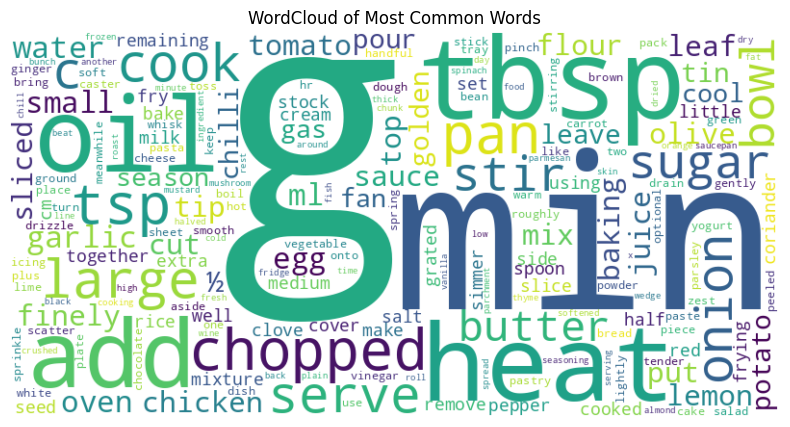

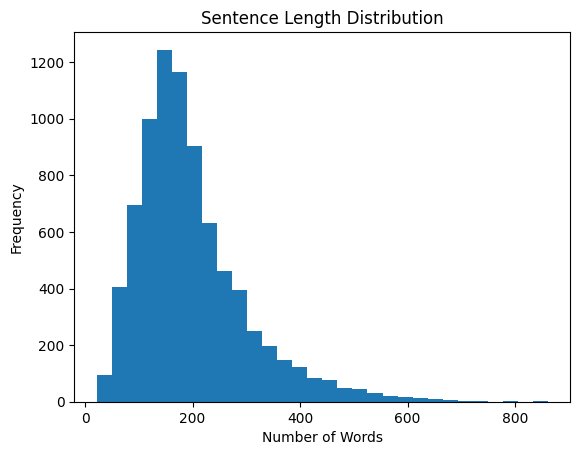

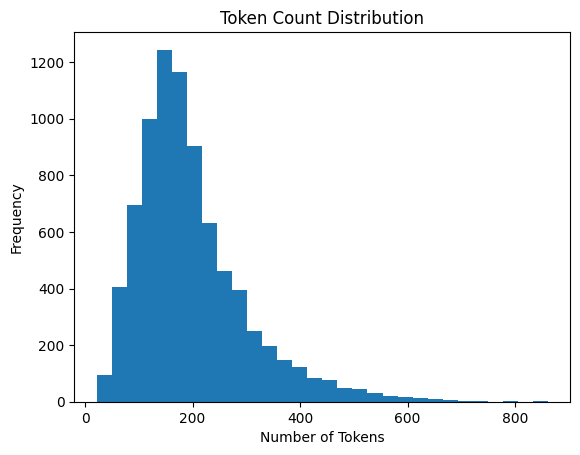

In [29]:
# Word Frequency Analysis
all_words = [word for tokens in data['lemmatized'] for word in tokens]
word_freq = Counter(all_words)

# Display most common words
print("Most Common Words:", word_freq.most_common(10))

# WordCloud Visualization
wordcloud = WordCloud(width=800, height=400,
background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Most Common Words")
plt.show()

# Sentence Length Distribution
data['sentence_length'] = data['cleaned_text'].apply(lambda x: len(x.split()))
data['sentence_length'].plot(kind='hist', bins=30, title="Sentence Length Distribution")
plt.xlabel("Number of Words")
plt.show()

# Token Count Distribution
data['token_count'] = data['tokens'].apply(len)
data['token_count'].plot(kind='hist', bins=30, title="Token Count Distribution")
plt.xlabel("Number of Tokens")
plt.show()

Examining the word cloud and word count, the most frequent token identified is "g", representing grams—a standard unit in cooking measurements. Other frequently occurring tokens include cooking-related terms such as "min," "tbspn," "heat," "oil," "add," "chopped," "pan," and "large." The high frequency of these terms is consistent with common culinary language.

Regarding the sentence length distribution histogram, the data shows a skewed distribution. Specifically, it is positively skewed—with a tall peak on the left side and a gradual tapering off to the right—indicating that most recipe instructions consist of shorter sentences (fewer tokens), with fewer recipes containing significantly longer instructions.

In the second histogram displaying the token count distribution, there is a notable frequency peak exceeding 1200 occurrences at approximately 180 tokens. This suggests that a considerable number of recipes have similar lengths around this token count, reflecting a common recipe complexity or standard length of instructions within the dataset. Overall, these findings highlight the typical structure and vocabulary consistency found within cooking instructions.

In [ ]:
# # Save the processed data
# data.to_csv("processed_data_with_eda.csv", index=False)
# print("Processed data with EDA saved as 'processed_data_with_eda.csv'.")

Processed data with EDA saved as 'processed_data_with_eda.csv'.


# 5. CHATBOT

Read in preprocessed dataset

In [65]:
recipe_path = "/Users/eoinhoustoun/Desktop/Goldsmiths/Semester 2/Natural Language Processing/CW1/processed_data_with_eda.csv"
recipe_df = pd.read_csv(recipe_path)

Preprocess user input

In [67]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Convert text data to numerical features
tfidf_matrix = vectorizer.fit_transform(recipe_df["cleaned_text"])  # You can use cleaned_text if preferred

# Store feature names (words)
feature_names = vectorizer.get_feature_names_out()

def extract_serving_number(x):
    if pd.isna(x):
        return ""
    try:
        # Convert from string to list
        x = ast.literal_eval(x)
        text = x[0] if isinstance(x, list) and len(x) > 0 else ""
        # Extract first number group from the text
        match = re.search(r'\d+(-\d+)?', text)
        return match.group(0) if match else ""
    except:
        return ""

recipe_df['Servings'] = recipe_df['Servings'].apply(extract_serving_number)

def preprocess_text(text):
    if isinstance(text, list):  # Handle Input
        text = " ".join(text)

    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    text = " ".join([stemmer.stem(word) for word in text.split() if word not in stop_words])  # Stemming & stopwords removal
    return text

## 5.1 Chatbot 1 - COSINE SIMILARITY - TF-IDF (NO UI)

Recognise if a user wants a low calorie meal or quick meal

In [84]:
def extract_numeric_constraints(user_query):
    """
    Extracts calorie and time constraints from the user query.
    Returns a dictionary with `max_calories` and `max_time`.
    """
    constraints = {}

    # Extract calorie constraints
    calorie_match = re.search(r'less than (\d+) calories', user_query, re.IGNORECASE)
    if calorie_match:
        constraints['max_calories'] = int(calorie_match.group(1))

    # Extract time constraints
    time_match = re.search(r'less than (\d+) minutes?', user_query, re.IGNORECASE)
    if time_match:
        constraints['max_time'] = int(time_match.group(1))

    return constraints

In [86]:
def get_filtered_recommendations(user_query, top_n=8):
    """
    Finds the top N most similar recipes while applying calorie and time constraints.
    """
    constraints = extract_numeric_constraints(user_query)
    processed_input = preprocess_text(user_query)

    # Convert user input into TF-IDF representation
    input_vector = vectorizer.transform([processed_input])

    # Compute similarity scores
    similarity_scores = cosine_similarity(input_vector, tfidf_matrix).flatten()
    recipe_df["Similarity Score"] = similarity_scores

    # Apply calorie and time filters
    filtered_df = recipe_df.copy()
    if 'max_calories' in constraints:
        filtered_df = filtered_df[filtered_df["Calories (g)"] <= constraints['max_calories']]
    if 'max_time' in constraints:
        filtered_df = filtered_df[filtered_df["Total Time (mins)"] <= constraints['max_time']]

    # Get top N filtered results
    recommended_recipes = filtered_df.nlargest(top_n, "Similarity Score")[["Title", "Calories (g)", "Total Time (mins)", "Ingredients", "Method"]]

    return recommended_recipes

The chatbot uses TF-IDF (Term Frequency–Inverse Document Frequency) to transform the user's input query into a numerical vector. TF-IDF gives more weight to unique, meaningful words while downplaying commonly used ones, helping to highlight the most relevant terms in the query. Once the input is vectorized, cosine similarity is used to compare it with the precomputed TF-IDF vectors of all recipes. Cosine similarity measures the angle between two vectors in high-dimensional space, indicating how similar the query is to each recipe based on word usage. This allows the system to rank recipes by relevance, even if the exact words don’t fully match, offering a more intelligent and flexible search than simple keyword matching.

Computed recipe recommendations based on cosine similarity, a measure of similarity between two vectors calculated by the cosine of the angle between them. It ranges from 0 (completely dissimilar) to 1 (identical). Cosine similarity is advantageous because it is computationally efficient and typically provides accurate, relevant results quickly.

However, cosine similarity relies heavily on direct textual similarity between user input and recipe descriptions. A limitation arises if a user searches specifically for a "pasta" dish—a recipe like "spaghetti bolognese" might not be ranked highly unless the word "pasta" explicitly appears in its description, despite spaghetti being a type of pasta. This demonstrates how cosine similarity may miss semantically related terms if they're not directly matched within the text.

In [89]:
def chatbot():
    """
    Interactive chatbot for recipe recommendations.
    """
    print("\n👩‍🍳 Welcome to the Recipe Bot! Type 'exit' to stop.\n")

    while True:
        # Get user query
        user_query = input("🗣️ You: ")
        if user_query.lower() == "exit":
            print("👋 Goodbye!")
            break

        recommendations = get_filtered_recommendations(user_query)

        if recommendations.empty:
            print("❌ Sorry, no recipes match your criteria. Try a different request!")
            continue

        # Display three recommended recipes
        print("\n✅ Here are some recipes for you:")
        for i, row in recommendations.iterrows():
            print(f"{i+1}. {row['Title']} 🕒 {row['Total Time (mins)']} mins | 🔥 {row['Calories (g)']} cal")

        # Ask if they like any of these options
        user_choice = input("\n🤖 Do any of these sound good to you? (yes/no) ").strip().lower()

        if user_choice == "yes":
            chosen_recipe = input("🤖 Which one? (Type the number or name) ").strip()

            # Find the selected recipe
            if chosen_recipe.isdigit():
                chosen_index = int(chosen_recipe) - 1
                if chosen_index in recommendations.index:
                    selected_recipe = recommendations.iloc[chosen_index]
                else:
                    print("❌ Invalid selection.")
                    continue
            else:
                matched_recipe = recommendations[recommendations["Title"].str.lower() == chosen_recipe.lower()]
                if matched_recipe.empty:
                    print("❌ Could not find that recipe.")
                    continue
                selected_recipe = matched_recipe.iloc[0]

            # Display recipe details
            print(f"\n📌 {selected_recipe['Title']}")
            print(f"🕒 Time: {selected_recipe['Total Time (mins)']} mins | 🔥 {selected_recipe['Calories (g)']} cal")
            print(f"\n🥕 **Ingredients:**\n{selected_recipe['Ingredients']}")
            print(f"\n👨‍🍳 **Method:**\n{selected_recipe['Method']}\n")
            break

        elif user_choice == "no":
            print("\n🔄 Finding more recipes...\n")
            continue
        else:
            print("❌ Please answer 'yes' or 'no'.")
            continue



### Chatbot 1 - Experiment 1

In [19]:
# Run the chatbot
chatbot()


👩‍🍳 Welcome to the Recipe Bot! Type 'exit' to stop.



🗣️ You:  pasta



✅ Here are some recipes for you:
1700. Air fryer pasta chips 🕒 30.0 mins | 🔥 144.0 cal
370. 15-minute chicken pasta 🕒 15.0 mins | 🔥 531.0 cal
3793. Walnut & red pepper pesto pasta 🕒 30.0 mins | 🔥 589.0 cal
5384. Anytime pesto & prawn pasta salad 🕒 25.0 mins | 🔥 567.0 cal
2278. Bacon & broccoli pasta 🕒 20.0 mins | 🔥 655.0 cal
2285. Bacon & broccoli pasta 🕒 20.0 mins | 🔥 655.0 cal
2248. Pasta with kale, chilli & mascarpone 🕒 25.0 mins | 🔥 513.0 cal
34. Healthy chicken pasta bake 🕒 60.0 mins | 🔥 480.0 cal



🤖 Do any of these sound good to you? (yes/no)  yes
🤖 Which one? (Type the number or name)  Pasta with kale, chilli & mascarpone



📌 Pasta with kale, chilli & mascarpone
🕒 Time: 25.0 mins | 🔥 513.0 cal

🥕 **Ingredients:**
300g pasta such as orecchiette or conchiglie, 4 tbsp mild olive oil, 4 anchovies in oil, drained, 1 red chilli thinly sliced (deseeded if you don't like it too hot), zest and juice 1 lemon, ½ tsp freshly grated nutmeg, 0.5 a 250g tub mascarpone, 250g kale large stalks removed, leaves shredded, 25g Grana Padano finely grated

👨‍🍳 **Method:**
Using the largest saucepan you have, boil the pasta in salted water following pack instructions and setting a timer. Meanwhile, heat the oil in a large frying pan, add the anchovies and chilli and fry gently for a couple of mins, stirring now and again, until the anchovies dissolve completely in the oil. Stir in the lemon zest and nutmeg and sizzle for a few secs. Stir in the mascarpone and half the lemon juice, then remove from the heat. When the pasta has 4 mins left, push the kale into the pasta pan, a handful at a time. It will seem like a lot, but it’ll 

### Chatbot 1 - Experiment 2

In [92]:
chatbot()


👩‍🍳 Welcome to the Recipe Bot! Type 'exit' to stop.



🗣️ You:  i want a meal that is less than 600 calories and takes less than 30 minutes to make



✅ Here are some recipes for you:
531. Grilled Thai salmon 🕒 15.0 mins | 🔥 281.0 cal
4920. Soft-boiled eggs 🕒 4.0 mins | 🔥 191.0 cal
1193. Curried mango & chickpea pot 🕒 15.0 mins | 🔥 327.0 cal
1469. Chapatis 🕒 25.0 mins | 🔥 121.0 cal
6534. Thai green curry paste 🕒 10.0 mins | 🔥 25.0 cal
1593. Pomegranate salad 🕒 20.0 mins | 🔥 243.0 cal
3160. Cranberry sauce with port & star anise 🕒 25.0 mins | 🔥 51.0 cal
4206. Crushed raspberry creams 🕒 10.0 mins | 🔥 214.0 cal



🤖 Do any of these sound good to you? (yes/no)  yes
🤖 Which one? (Type the number or name)  Grilled Thai salmon



📌 Grilled Thai salmon
🕒 Time: 15.0 mins | 🔥 281.0 cal

🥕 **Ingredients:**
4 x 140g/5oz salmon fillets, 2 tsp sunflower oil, small knob of root ginger peeled and grated, 1 mild red chilli finely sliced (deseed if you want less heat), bunch spring onions finely sliced, 1 ½ tbsp sweet soy sauce, ¼ tsp sugar, 1 x 20g pack coriander leaves only chopped

👨‍🍳 **Method:**
Heat grill to high. Place the fish in a shallow baking dish, then grill for 4-5 mins until cooked through, but still a little pink in the centre. Cover and set aside. Heat a wok, add the oil, then stir-fry the ginger, chilli and spring onions for 2-3 mins. Stir in the soy, sugar and a splash of water, then take off the heat. Throw in the coriander and serve immediately with the salmon. Delicious with rice or noodles.



### Chatbot 1 - Experiment 3

In [96]:
chatbot()


👩‍🍳 Welcome to the Recipe Bot! Type 'exit' to stop.



🗣️ You:  i would like pasta that is less than 500 calories



✅ Here are some recipes for you:
1700. Air fryer pasta chips 🕒 30.0 mins | 🔥 144.0 cal
34. Healthy chicken pasta bake 🕒 60.0 mins | 🔥 480.0 cal
907. Beany pasta pot 🕒 20.0 mins | 🔥 233.0 cal
2367. Favourite pasta salad 🕒 22.0 mins | 🔥 292.0 cal
5309. Roasted ratatouille pasta 🕒 45.0 mins | 🔥 450.0 cal
1499. Pasta with tomato & hidden veg sauce 🕒 65.0 mins | 🔥 411.0 cal
7434. Tomato & aubergine pasta 🕒 30.0 mins | 🔥 488.0 cal
7444. Tomato & aubergine pasta 🕒 30.0 mins | 🔥 488.0 cal



🤖 Do any of these sound good to you? (yes/no)  yes
🤖 Which one? (Type the number or name)  Tomato & aubergine pasta



📌 Tomato & aubergine pasta
🕒 Time: 30.0 mins | 🔥 488.0 cal

🥕 **Ingredients:**
400g pasta shapes, 2 tbsp  olive oil, 1 large  aubergine cut into cubes, 2 garlic cloves sliced, pinch  sugar, 8 large ripe tomatoes roughly chopped, 2 tbsp  capers rinsed, handful flat-leaf  parsley roughly chopped

👨‍🍳 **Method:**
Boil the pasta according to pack instructions. Meanwhile, heat the oil in a frying pan and fry the aubergine for 5 mins. Season to taste. Add garlic and sugar, and fry for another 2 mins until the garlic is softened. Tip the tomatoes, capers and parsley into the pan, warm through briefly then fold through the cooked, drained pasta.



### Chatbot 1 - Experiment Discussion

The chatbot successfully generated meals matching user inputs during the initial experiments:

- Experiment 1: When prompted with a request for a pasta dish, the chatbot returned a suitable and appealing suggestion, specifically a chicken pasta bake.

- Experiment 2: Upon requesting meals with specific nutritional constraints, less than 600 calories and preparation under 30 minutes, the chatbot successfully provided a list of meals matching these criteria, demonstrating effective filtering.

- Experiment 3: A combined query requesting a pasta dish with fewer than 500 calories resulted in relevant, healthy pasta options, confirming the chatbot’s practical usefulness in meal selection.
However, several notable limitations currently exist with this initial version:

It cannot handle general conversational queries or specific dietary substitutions (e.g., replacing milk with a dairy-free alternative).
Recipe instructions and ingredient lists are presented as plain blocks of text, lacking visual appeal or readability enhancements.
The chatbot operates solely within a Jupyter Notebook environment, lacking a user-friendly graphical interface

### Chatbot 1 - Experiment 3 - Live for video

In [ ]:
chatbot()

## 5.2 Chatbot 2 - Word Matching (No UI)

The keyword-matching approach implemented in this chatbot searches directly for the presence of specific words entered by the user in the recipe dataset. When a user inputs a query (e.g., "pasta"), the chatbot scans the recipe titles, ingredients, and searchable descriptions, returning recipes containing those exact words. This method is straightforward, fast, and easy to interpret, but it relies entirely on exact keyword matches, limiting its ability to recognize recipes described by related or synonymous terms.

In [75]:
# ✅ Function to search for matching recipes
def search_recipes(user_query, top_n=8):
    constraints = extract_numeric_constraints(user_query)

    # 🏆 **Search recipes by title, ingredients, and searchable text**
    filtered_df = recipe_df[
        recipe_df["Searchable_Text"].str.contains(user_query, case=False, na=False) |
        recipe_df["Title"].str.contains(user_query, case=False, na=False) |
        recipe_df["Ingredients"].str.contains(user_query, case=False, na=False)
    ].copy()

    # 🏆 **Apply calorie and time filters**
    if 'max_calories' in constraints:
        filtered_df = filtered_df[filtered_df["Calories (g)"] <= constraints['max_calories']]
    if 'max_time' in constraints:
        filtered_df = filtered_df[filtered_df["Total Time (mins)"] <= constraints['max_time']]

    return filtered_df.head(top_n)  # Return top matching recipes

# ✅ Chatbot UI Elements
chat_output = widgets.Output()
user_input = widgets.Text(placeholder="Tell me what you’re craving! (e.g., 'I want a quick pasta under 400 calories')")
send_button = widgets.Button(description="Send", button_style='primary')

recipe_dropdown = widgets.Dropdown(options=[], description="Pick one:", disabled=True)
select_button = widgets.Button(description="Show Details", button_style='success', disabled=True)
none_button = widgets.Button(description="None, Show More", button_style='danger', disabled=True)

# Store the current recommendations
current_recommendations = pd.DataFrame()

# ✅ Function to display chatbot messages
def display_message(message, sender="Chatbot"):
    with chat_output:
        if sender == "Chatbot":
            print(f"🤖 {message}")
        else:
            print(f"🗣️ You: {message}")

# ✅ Function to handle user input
def handle_user_input(_):
    global current_recommendations
    
    user_query = user_input.value.strip()
    if not user_query:
        return  # Ignore empty input

    # Display user message
    display_message(user_query, sender="User")
    
    # Get matching recipes
    current_recommendations = search_recipes(user_query)

    # Clear previous dropdown options
    recipe_dropdown.options = []
    recipe_dropdown.disabled = False

    if current_recommendations.empty:
        display_message("Oh no! 😢 I couldn't find anything that matches your request. Try a different description!")
        recipe_dropdown.disabled = True
        select_button.disabled = True
        none_button.disabled = True
    else:
        display_message("Great choice! I found some tasty options for you. Which one would you like to try?")
        recipe_dropdown.options = list(current_recommendations["Title"])
        select_button.disabled = False
        none_button.disabled = False

    # Clear input box
    user_input.value = ""

# ✅ Function to show selected recipe details
def show_recipe_details(_):
    selected_recipe_title = recipe_dropdown.value
    recipe = current_recommendations[current_recommendations["Title"] == selected_recipe_title]
    
    if not recipe.empty:
        recipe = recipe.iloc[0]
        display_message(f"🍽️ **{recipe['Title']}**")
        display_message(f"⏳ **Time:** {recipe['Total Time (mins)']} mins | 🔥 **Calories:** {recipe['Calories (g)']} cal")
        display_message(f"🥕 **Ingredients:** {recipe['Ingredients']}")
        display_message(f"👨‍🍳 **Instructions:** {recipe['Method']}\n")
        display_message("Let me know if you need another recipe! 😊")

# ✅ Function to show more recommendations
def show_more_recommendations(_):
    global current_recommendations
    display_message("🔄 No problem! Let me find something else for you...")
    current_recommendations = current_recommendations.iloc[1:]  # Remove the first one
    
    if current_recommendations.empty:
        display_message("Uh-oh! Looks like we're out of options. Try a new request! 😊")
        recipe_dropdown.disabled = True
        select_button.disabled = True
        none_button.disabled = True
    else:
        recipe_dropdown.options = list(current_recommendations["Title"])
        display_message("Here are some new options! Hope you find something you like. 😃")

# ✅ Bind functions to buttons
send_button.on_click(handle_user_input)
select_button.on_click(show_recipe_details)
none_button.on_click(show_more_recommendations)


### Chatbot 2 - Experiment 1

In [77]:
# ✅ Display UI
display(chat_output)
display(widgets.HBox([user_input, send_button]))
display(widgets.HBox([recipe_dropdown, select_button, none_button]))


Output()

### Chatbot 2 - Experiment Discussion

The keyword-matching method had significant limitations compared to the TF-IDF and cosine similarity approach. Keyword matching only worked effectively when the user input exactly matched words present in the dataset, and it struggled to interpret or recognize more descriptive sentences. Although the user interface was improved with interactive buttons, the underlying retrieval algorithm remained inadequate. Due to this, further experimentation with this keyword-based model was not continued.

## 5.3 Chatbot 3 - COSINE SIMILARITY - TF-IDF (No UI) with Buttons

In [91]:
# ✅ Precompute TF-IDF Matrix
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(recipe_df["Searchable_Text"].fillna(""))

# ✅ Function to find similar recipes using Cosine Similarity
def search_recipes(user_query, top_n=12):
    constraints = extract_numeric_constraints(user_query)

    # Transform user input into TF-IDF vector
    user_query_tfidf = vectorizer.transform([user_query])

    # Compute cosine similarity
    cosine_similarities = cosine_similarity(user_query_tfidf, tfidf_matrix).flatten()

    # Get top matching recipes
    recipe_df["Similarity"] = cosine_similarities
    filtered_df = recipe_df.sort_values(by="Similarity", ascending=False).head(top_n)

    # Apply calorie and time filters
    if 'max_calories' in constraints:
        filtered_df = filtered_df[filtered_df["Calories (g)"] <= constraints['max_calories']]
    if 'max_time' in constraints:
        filtered_df = filtered_df[filtered_df["Total Time (mins)"] <= constraints['max_time']]

    return filtered_df


Returning to the cosine similarity method for meal search

In [94]:
# # 🛠️ Clear previous widgets to prevent duplication
# for widget in [w for w in globals().values() if isinstance(w, widgets.Widget)]:
#     widget.close()

# ✅ Chatbot UI Elements
chat_output = widgets.Output()
user_input = widgets.Text(placeholder="Meal? (e.g., 'I want pasta less than 600 calories')")
send_button = widgets.Button(description="Send", button_style='primary')

recipe_dropdown = widgets.Dropdown(options=[], description="Pick one:", disabled=True)
select_button = widgets.Button(description="Show Details", button_style='success', disabled=True)
none_button = widgets.Button(description="None, Show More", button_style='danger', disabled=True)

# Store the current recommendations
current_recommendations = pd.DataFrame()

# ✅ Function to display chatbot messages with Markdown formatting
def display_message(message, sender="Chatbot"):
    with chat_output:
        if sender == "Chatbot":
            display(Markdown(f"**🤖👨‍🍳 AI CHEF...** {message}"))
        else:
            display(Markdown(f"**🗣️ YOU:** {message}"))

# ✅ Function to format ingredients as a bulleted list (Fixes Formatting Issue)
def format_ingredients(ingredients):
    # Ensure proper separation by splitting at **", "** or **"\n"**
    ingredient_list = re.split(r',\s*|\n', ingredients.strip())
    return "\n".join([f"- {item.strip()}" for item in ingredient_list if item.strip()])

# ✅ Function to format method steps as a numbered list (Fixes Formatting Issue)
def format_method(method):
    # Ensure correct sentence splitting (handles cases where the first sentence was misformatted)
    steps = re.split(r'\.\s+(?=[A-Z])', method.strip())  # Split where a period is followed by a capital letter
    return "\n".join([f"{i+1}. {step.strip()}." for i, step in enumerate(steps)])

# ✅ Function to handle user input
def handle_user_input(_):
    global current_recommendations
    
    user_query = user_input.value.strip()
    if not user_query:
        return  # Ignore empty input

    # Display user message
    display_message(user_query, sender="User")
    
    # Get matching recipes using Cosine Similarity
    current_recommendations = search_recipes(user_query)

    # Clear previous dropdown options
    recipe_dropdown.options = []
    recipe_dropdown.disabled = False

    if current_recommendations.empty:
        display_message("Oh no! 😢 I couldn't find anything that matches your request. Try a different description!")
        recipe_dropdown.disabled = True
        select_button.disabled = True
        none_button.disabled = True
    else:
        display_message("Generating tasty options... **Pick one to see details:**")
        recipe_dropdown.options = list(current_recommendations["Title"])
        select_button.disabled = False
        none_button.disabled = False

    # Clear input box
    user_input.value = ""

# ✅ Function to show selected recipe details with Markdown formatting
def show_recipe_details(_):
    selected_recipe_title = recipe_dropdown.value
    recipe = current_recommendations[current_recommendations["Title"] == selected_recipe_title]
    
    if not recipe.empty:
        recipe = recipe.iloc[0]
        
        formatted_ingredients = format_ingredients(recipe['Ingredients'])
        formatted_method = format_method(recipe['Method'])

        display_message(f"Great choice! I think you will really enjoy this meal!")
        display_message(f"🍽️ **Meal:** {recipe['Title']}\n")
        display_message(f"⏳ **Time:** {recipe['Total Time (mins)']} mins \n")
        display_message(f"👥 **Servings:** {recipe['Servings']}")
        display_message(f"🔥 **Calories:** {recipe['Calories (g)']} cal \n")
        display_message(f"🥕 **Ingredients:** \n {formatted_ingredients}\n")
        display_message(f"👨‍🍳 **Instructions:** \n {formatted_method}\n") 

# ✅ Function to show more recommendations
def show_more_recommendations(_):
    global current_recommendations
    display_message("🔄 Looking for more options...")

    if len(current_recommendations) > 1:
        current_recommendations.drop(current_recommendations.index[0], inplace=True)  # Remove the first one
        recipe_dropdown.options = list(current_recommendations["Title"])
        display_message("Here are some new options! Hope you find something you like. 😃")
    else:
        display_message("Uh-oh! Looks like we're out of options. Try a new request! 😊")
        recipe_dropdown.disabled = True
        select_button.disabled = True
        none_button.disabled = True

# ✅ Bind functions to buttons
send_button.on_click(handle_user_input)
select_button.on_click(show_recipe_details)
none_button.on_click(show_more_recommendations)


### Chatbot 3 - Experiment 1

In [97]:
# ✅ Display UI
display(chat_output)
display(widgets.HBox([user_input, send_button]))
display(widgets.HBox([recipe_dropdown, select_button, none_button]))


Output()

### Chatbot 3 - Experiment 2 - Live for video

In [ ]:
# ✅ Display UI
display(chat_output)
display(widgets.HBox([user_input, send_button]))
display(widgets.HBox([recipe_dropdown, select_button, none_button]))

### Chatbot 3 - Experiment Discussion

This version of the chatbot has been the most effective so far. Using cosine similarity on TF-IDF vectors resulted in accurate recipe recommendations, and the addition of interactive buttons significantly improved the user experience. On top of that, the formatting of the ingredients and instructions is now much clearer and easier to read, and the inclusion of serving size adds even more useful context for the user.

## 5.4 Chatbot 4 - COSINE SIMILARITY - TF-IDF (WITH UI)

In [44]:
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk 

%gui tk


### Chatbot 4 - Experiment 1 - Live for Video (BEST CHATBOT)

In [46]:
# ✅ Start Tkinter GUI
root = tk.Tk()
root.title("AI Chef Chatbot")
root.geometry("1400x1000")  # Increased window size
root.configure(bg="lightblue")

# ✅ Function to transition from Welcome Screen → Chatbot
def show_chatbot():
    welcome_frame.pack_forget()  # Hide the welcome screen
    chatbot_frame.pack(pady=20)  # Show chatbot screen

# ✅ Welcome Screen UI
welcome_frame = tk.Frame(root, bg="lightblue")
welcome_frame.pack(fill="both", expand=True)

# Load and display the chef image
image_path = "chef_image.png" 

chef_img = Image.open(image_path)
chef_img = chef_img.resize((450, 450))  # 🔹 Increased size
chef_photo = ImageTk.PhotoImage(chef_img)

# ✅ Store a reference to avoid garbage collection
chef_label = tk.Label(welcome_frame, image=chef_photo, bg="lightblue")
chef_label.image = chef_photo  # ✅ Keep reference!
chef_label.pack(pady=20)

# Welcome message
welcome_label = tk.Label(
    welcome_frame, 
    text="👨‍🍳 Welcome to AI Chef!\nAre you ready to cook some tasty meals?",
    font=("Arial", 24, "bold"),  # 🔹 Increased font size
    bg="white"
)
welcome_label.pack(pady=20)

# Start Button
start_button = tk.Button(
    welcome_frame, 
    text="Yes, Let's Cook!", 
    font=("Arial", 24, "bold"),  # 🔹 Bigger button text
    bg="green", 
    padx=20, 
    pady=10, 
    command=show_chatbot
)
start_button.pack(pady=30)

# ✅ Chatbot Frame (Hidden at first)
chatbot_frame = tk.Frame(root, bg="black")

# User Input Box
user_input_label = tk.Label(
    chatbot_frame, 
    text="What do you feel like eating?", 
    font=("Arial", 18, "bold"),  # 🔹 Bigger font
    bg="white"
)
user_input_label.pack()

user_input = tk.Entry(
    chatbot_frame, 
    width=50, 
    font=("Arial", 16)  # 🔹 Bigger text input box
)
user_input.pack(pady=10)

# Function to handle chatbot interaction with loading animation
def handle_user_input():
    query = user_input.get().strip()
    if not query:
        return

    # Clear previous results
    recipe_dropdown["menu"].delete(0, "end")
    response_label.config(text="How do these sounds")  # Initial text

    # Start the loading animation
    animate_loading(0)

    # Delay the recipe search to simulate real-world loading
    root.after(1200, complete_search, query)  # Simulates a 1.2s "search"

# Function to animate loading dots (".", "..", "...")
def animate_loading(count):
    dots = ["", ".", "..", "..."]  # Animation sequence
    response_label.config(text=f"Hmmm, generating ideas{dots[count % len(dots)]}")
    if count < 6:  # Number of cycles (Adjustable)
        root.after(300, lambda: animate_loading(count + 1))  # Update every 300ms

# Function to complete the search after animation
def complete_search(query):
    global current_recommendations
    current_recommendations = search_recipes(query)

    if current_recommendations.empty:
        response_label.config(text="❌ Sorry, no recipes match your request. Try a different query!")
        return

    # Update dropdown menu with recipe titles
    response_label.config(text="✅ Here are some delicious options! Select one below:")
    for title in current_recommendations["Title"]:
        recipe_dropdown["menu"].add_command(label=title, command=lambda t=title: show_recipe_details(t))
    recipe_var.set(current_recommendations["Title"].iloc[0])  # Default selection


# Search Button
search_button = tk.Button(
    chatbot_frame, 
    text="Find Recipes", 
    bg="green", 
    font=("Arial", 28, "bold"),  # 🔹 Bigger button text
    padx=20, 
    pady=10, 
    command=handle_user_input
)
search_button.pack(pady=10)

# Dropdown for Recipe Selection
recipe_var = tk.StringVar()
recipe_dropdown = tk.OptionMenu(chatbot_frame, recipe_var, [])
recipe_dropdown.config(font=("Arial", 26))  # 🔹 Bigger dropdown menu
recipe_dropdown.pack(pady=15)


# Response Label
response_label = tk.Label(
    chatbot_frame, 
    text="", 
    font=("Arial", 24, "bold"),  # 🔹 Bigger response font
    bg="green"
)
response_label.pack()

# Recipe Details Label
recipe_details_label = tk.Label(
    chatbot_frame, 
    text="", 
    font=("Arial", 26),  # 🔹 Bigger recipe details font
    bg="black", 
    justify="left"
)
recipe_details_label.pack()


# Function to display recipe details with a scrollable text box
def show_recipe_details(selected_title):
    recipe = current_recommendations[current_recommendations["Title"] == selected_title].iloc[0]
    ingredients = format_ingredients(recipe["Ingredients"])
    method = format_method(recipe["Method"])

    # Clear previous text
    recipe_details_text.config(state="normal")  # Allow editing temporarily
    recipe_details_text.delete("1.0", tk.END)   # Clear text area

    # Insert new recipe details
    recipe_details_text.insert(
        tk.END, 
        f"🍽️ {recipe['Title']}\n"
        f"⏳ Time: {recipe['Total Time (mins)']} mins\n"
        f"🔥 Calories: {recipe['Calories (g)']} cal\n"
        f"👥 Servings: {recipe['Servings']}\n\n"
        f"🥕 Ingredients:\n{ingredients}\n\n"
        f"👨‍🍳 Instructions:\n{method}"
    )

    # Disable editing
    recipe_details_text.config(state="disabled")

# Create a Frame for scrollable text
details_frame = tk.Frame(chatbot_frame, bg="blue")
details_frame.pack(fill="both", expand=True, padx=20, pady=10)

# Create Scrollbar
details_scrollbar = tk.Scrollbar(details_frame)
details_scrollbar.pack(side="right", fill="y")

# Create Text Widget for Recipe Details
recipe_details_text = tk.Text(
    details_frame, 
    wrap="word",  # Ensures words don't cut off
    font=("Arial", 22), 
    bg="lightyellow", 
    height=18,  # Adjust height as needed
    width=120  # Adjust width as needed
)
recipe_details_text.pack(fill="both", expand=False)

# Link Scrollbar to Text Widget
recipe_details_text.config(yscrollcommand=details_scrollbar.set)
details_scrollbar.config(command=recipe_details_text.yview)

# Make text read-only by default
recipe_details_text.config(state="disabled")


# ✅ Initially hide chatbot UI
chatbot_frame.pack_forget()

# Run Tkinter event loop
root.mainloop()


### Chatbot 4 - Discussion

This chatbot recommends cooking recipes based on user input using a combination of NLP techniques and a graphical user interface (GUI) built with Tkinter. 

##### Text Representation using TF-IDF

The central NLP technique used in this chatbot is the Term Frequency-Inverse Document Frequency (TF-IDF) vectorization. This method transforms textual data into numeric vectors by considering how frequently a term appears within a single document compared to its frequency across all documents.

```python
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(recipe_df["Searchable_Text"].fillna(""))
```

- **Stop words** such as "the", "is", and "in" are removed to enhance the effectiveness of the vectorization process.
- Each recipe is represented as a high-dimensional sparse vector, emphasizing unique terms that distinguish one recipe from another.

#### Cosine Similarity for Recipe Retrieval

After vectorization, cosine similarity is used to measure the similarity between user queries and available recipes.

```python
user_query_tfidf = vectorizer.transform([user_query])
cosine_similarities = cosine_similarity(user_query_tfidf, tfidf_matrix).flatten()
```

- Cosine values closer to 1 indicate higher semantic similarity.
- This allows the chatbot to efficiently identify and recommend the most relevant recipes based on textual content.

#### Constraint Extraction via Regular Expressions

An additional layer of user query parsing is done through regular expressions to identify numeric constraints related to calories and preparation time explicitly mentioned by users.

```python
def extract_numeric_constraints(user_query):
    constraints = {}
    calorie_match = re.search(r'less than (\d+) calories', user_query, re.IGNORECASE)
    if calorie_match:
        constraints['max_calories'] = int(calorie_match.group(1))
    time_match = re.search(r'less than (\d+) minutes?', user_query, re.IGNORECASE)
    if time_match:
        constraints['max_time'] = int(time_match.group(1))
    return constraints
```

- Enables users to filter recommendations by practical constraints, enhancing the chatbot's usability and responsiveness.

#### Recipe Search and Filtering

Upon user input, the chatbot performs a structured sequence:

1. **Input Parsing:** User query is obtained from the GUI.
2. **Constraint Extraction:** Numeric constraints are parsed and applied to the filtering process.
3. **Semantic Matching:** TF-IDF vectorization and cosine similarity are applied to rank recipes.
4. **Filtering:** Results are filtered based on user-specified constraints, e.g., calories or preparation time.

#### Recipe Formatting

The chatbot formats retrieved recipes in an organized and user-friendly manner:

- **Ingredients:** Parsed and formatted into bullet points for clarity.
- **Instructions:** Separated into numbered steps, making recipes easy to follow.

```python
def format_ingredients(ingredients):
    ingredient_list = re.split(r',\s*|\n', ingredients.strip())
    return "\n".join([f"• {item.strip()}" for item in ingredient_list if item.strip()])

def format_method(method):
    steps = re.split(r'\.\s+(?=[A-Z])', method.strip())
    return "\n".join([f"{i+1}. {step.strip()}." for i, step in enumerate(steps)])
```

#### User Interface Design with Tkinter

The GUI used Python's Tkinter library for interaction:

- **Welcome Screen:** Engaging introduction with interactive elements such as buttons and images.
- **Chat Interface:** Allows users to enter natural-language queries, view loading animations, and browse recipe recommendations.
- **Dynamic Loading Animation:** For user experience by simulating thoughtful AI processing.

```python
def animate_loading(count):
    dots = ["", ".", "..", "..."]
    response_label.config(text=f"Hmmm, generating ideas{dots[count % len(dots)]}")
    if count < 6:
        root.after(300, lambda: animate_loading(count + 1))
```

This recipe recommendation chatbot combines NLP techniques with interactive GUI design to create an intuitive and effective culinary assistant. By integrating semantic matching and numeric constraint extraction, the chatbot delivers precise and personalized recipe recommendations, enhancing both accuracy and user satisfaction. The structured, user-friendly presentation of recipe information ensures that users can easily follow suggested cooking steps, making the chatbot an advanced yet accessible cooking guide.



## 5.5 Chatbot 5 - COSINE SIMILARITY - DISTILBERT

In [487]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')


In [18]:
def generate_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Generate embeddings for all recipes (run once)
# recipe_df["Embeddings"] = recipe_df["Searchable_Text"].apply(generate_embedding)
# recipe_df.to_csv('recipe_dataset_with_embeddings.csv', index=False)


After generating and storing embeddings, the dataset was saved to avoid the need to recompute embeddings in the future.

In [48]:
recipe_path = "/Users/eoinhoustoun/Desktop/Goldsmiths/Semester 2/Natural Language Processing/CW1/recipe_dataset_with_embeddings.csv"
recipe_df = pd.read_csv(recipe_path)

In [49]:
recipe_df["Embeddings"]

0       [-3.27622890e-01  5.55241555e-02  1.13760792e-...
1       [-1.92369565e-01  1.42500952e-01  1.67612046e-...
2       [-2.60142446e-01  1.66524544e-01  2.81558812e-...
3       [-1.44976541e-01  6.36705905e-02  7.62897208e-...
4       [-2.91995317e-01  1.61921661e-02  1.07578538e-...
                              ...                        
8059    [-1.74251214e-01  3.38386409e-02  2.01003879e-...
8060    [-1.53555155e-01  7.50542656e-02  1.86633080e-...
8061    [-1.36152491e-01  8.81824791e-02  1.98441073e-...
8062    [-2.25102767e-01  1.49389476e-01  1.80696324e-...
8063    [-1.43563762e-01  1.34963542e-01  1.36117324e-...
Name: Embeddings, Length: 8064, dtype: object

### Chatbot 5 - Experiment 1 - Live for Video

In [50]:
# Load precomputed embeddings
df = recipe_df.copy()
df["Embeddings"] = df["Embeddings"].apply(lambda x: np.fromstring(x.strip("[]"), sep=' '))

# Initialize DistilBERT
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)

# Generate query embeddings
def generate_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

### ✅ Step 2: Search and Filtering Functions

def search_recipes_distilbert(user_query, top_n=12):
    query_embedding = generate_embedding(user_query).reshape(1, -1)
    recipe_embeddings = np.vstack(df["Embeddings"].values)
    cosine_similarities = cosine_similarity(query_embedding, recipe_embeddings).flatten()
    df["Similarity"] = cosine_similarities
    #filtered_df = df.sort_values(by="Similarity", ascending=False).head(top_n)
    filtered_df = df.nlargest(top_n, "Similarity")

    constraints = extract_numeric_constraints(user_query)
    if 'max_calories' in constraints:
        filtered_df = filtered_df[filtered_df["Calories (g)"] <= constraints['max_calories']]
    if 'max_time' in constraints:
        filtered_df = filtered_df[filtered_df["Total Time (mins)"] <= constraints['max_time']]
        
    return filtered_df


### ✅ Step 3: Text Formatting Functions

def format_ingredients(ingredients):
    ingredient_list = re.split(r',\s*|\n', ingredients.strip())
    return "\n".join([f"• {item.strip()}" for item in ingredient_list if item.strip()])

def format_method(method):
    steps = re.split(r'\.\s+(?=[A-Z])', method.strip())
    return "\n".join([f"{i+1}. {step.strip()}." for i, step in enumerate(steps)])


### ✅ Step 4: Tkinter GUI
root = tk.Tk()
root.title("AI Chef Chatbot")
root.geometry("1400x1000")
root.configure(bg="lightblue")

welcome_frame = tk.Frame(root, bg="brown")
welcome_frame.pack(fill="both", expand=True)

chef_img = Image.open("chef_image.png").resize((450, 450))
chef_photo = ImageTk.PhotoImage(chef_img)
chef_label = tk.Label(welcome_frame, image=chef_photo, bg="brown")
chef_label.image = chef_photo
chef_label.pack(pady=20)

welcome_label = tk.Label(welcome_frame, text="👨‍🍳 Welcome to AI Chef!\nReady to cook some tasty meals?", font=("Arial", 24, "bold"), bg="brown")
welcome_label.pack(pady=20)

start_button = tk.Button(welcome_frame, text="Yes, Let's Cook!", font=("Arial", 24, "bold"), bg="green", padx=20, pady=10, command=lambda:[welcome_frame.pack_forget(), chatbot_frame.pack(pady=20)])
start_button.pack(pady=30)

chatbot_frame = tk.Frame(root, bg="black")

user_input_label = tk.Label(chatbot_frame, text="What do you feel like eating?", font=("Arial", 18, "bold"), bg="white")
user_input_label.pack()
user_input = tk.Entry(chatbot_frame, width=50, font=("Arial", 16))
user_input.pack(pady=10)

response_label = tk.Label(chatbot_frame, text="", font=("Arial", 28, "bold"), bg="yellow")
response_label.pack()

recipe_var = tk.StringVar()
recipe_dropdown = tk.OptionMenu(chatbot_frame, recipe_var, [])
recipe_dropdown.config(font=("Arial", 26))
recipe_dropdown.pack(pady=15)

def handle_user_input():
    query = user_input.get().strip()
    if not query: return
    recipe_dropdown["menu"].delete(0, "end")
    response_label.config(text="Searching...")
    root.after(1200, lambda:complete_search(query))

def complete_search(query):
    global current_recommendations
    current_recommendations = search_recipes_distilbert(query)
    if current_recommendations.empty:
        response_label.config(text="❌ No matches found. Try again!")
        return
    response_label.config(text="✅ Select a recipe below:")
    for title in current_recommendations["Title"]:
        recipe_dropdown["menu"].add_command(label=title, command=lambda t=title: show_recipe_details(t))
    recipe_var.set(current_recommendations["Title"].iloc[0])

search_button = tk.Button(chatbot_frame, text="Find Recipes", bg="black", font=("Arial", 28, "bold"), padx=20, pady=10, command=handle_user_input)
search_button.pack(pady=10)

recipe_details_text = tk.Text(chatbot_frame, wrap="word", font=("Arial", 20), bg="lightyellow", height=15, width=100)
recipe_details_text.pack(pady=20)

def show_recipe_details(selected_title):
    recipe = current_recommendations[current_recommendations["Title"] == selected_title].iloc[0]
    details = f"🍽️ {recipe['Title']}\n⏳ {recipe['Total Time (mins)']} mins\n🔥 {recipe['Calories (g)']} cal\n\n🥕 Ingredients:\n{format_ingredients(recipe['Ingredients'])}\n\n👨‍🍳 Instructions:\n{format_method(recipe['Method'])}"
    recipe_details_text.config(state="normal")
    recipe_details_text.delete("1.0", tk.END)
    recipe_details_text.insert(tk.END, details)
    recipe_details_text.config(state="disabled")

chatbot_frame.pack_forget()
root.mainloop()




## 5.6 Chatbot 6 - COSINE SIMILARITY - Recipe Bert

In [418]:
model_name = "alexdseo/RecipeBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/664 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at alexdseo/RecipeBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [421]:
def generate_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()


In [ ]:
# Generate embeddings for all recipes (run once)
# recipe_df["Recipe_Embeddings"] = recipe_df["Searchable_Text"].apply(generate_embedding)
# recipe_df.to_csv('recipe_dataset_with_recipe_embeddings.csv', index=False)


### Chatbot 6 - Experiment 1 - Live for Video

In [477]:
### ✅ Step 1: Load precomputed embeddings
df = pd.read_csv('recipe_dataset_with_recipe_embeddings.csv')
df["Recipe_Embeddings"] = df["Recipe_Embeddings"].apply(lambda x: np.fromstring(x.strip("[]"), sep=' '))

model_name = "alexdseo/RecipeBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

### ✅ Step 2: Search and Filtering Functions

def search_recipes_recipebert(user_query, top_n=12):
    query_embedding = generate_embedding(user_query).reshape(1, -1)
    recipe_embeddings = np.vstack(df["Recipe_Embeddings"].values)
    cosine_similarities = cosine_similarity(query_embedding, recipe_embeddings).flatten()
    df["Similarity_r"] = cosine_similarities
    #filtered_df = df.sort_values(by="Similarity", ascending=False).head(top_n)
    filtered_df = df.nlargest(top_n, "Similarity_r")

    constraints = extract_numeric_constraints(user_query)
    if 'max_calories' in constraints:
        filtered_df = filtered_df[filtered_df["Calories (g)"] <= constraints['max_calories']]
    if 'max_time' in constraints:
        filtered_df = filtered_df[filtered_df["Total Time (mins)"] <= constraints['max_time']]
        
    return filtered_df


### ✅ Step 3: Text Formatting Functions

def format_ingredients(ingredients):
    ingredient_list = re.split(r',\s*|\n', ingredients.strip())
    return "\n".join([f"• {item.strip()}" for item in ingredient_list if item.strip()])

def format_method(method):
    steps = re.split(r'\.\s+(?=[A-Z])', method.strip())
    return "\n".join([f"{i+1}. {step.strip()}." for i, step in enumerate(steps)])


### ✅ Step 4: Tkinter GUI
root = tk.Tk()
root.title("AI Chef Chatbot")
root.geometry("1400x1000")
root.configure(bg="lightblue")

welcome_frame = tk.Frame(root, bg="brown")
welcome_frame.pack(fill="both", expand=True)

chef_img = Image.open("chef_image.png").resize((450, 450))
chef_photo = ImageTk.PhotoImage(chef_img)
chef_label = tk.Label(welcome_frame, image=chef_photo, bg="brown")
chef_label.image = chef_photo
chef_label.pack(pady=20)

welcome_label = tk.Label(welcome_frame, text="👨‍🍳 Welcome to AI Chef!\nReady to cook some tasty meals?", font=("Arial", 24, "bold"), bg="brown")
welcome_label.pack(pady=20)

start_button = tk.Button(welcome_frame, text="Yes, Let's Cook!", font=("Arial", 24, "bold"), bg="green", padx=20, pady=10, command=lambda:[welcome_frame.pack_forget(), chatbot_frame.pack(pady=20)])
start_button.pack(pady=30)

chatbot_frame = tk.Frame(root, bg="black")

user_input_label = tk.Label(chatbot_frame, text="What do you feel like eating?", font=("Arial", 18, "bold"), bg="white")
user_input_label.pack()
user_input = tk.Entry(chatbot_frame, width=50, font=("Arial", 16))
user_input.pack(pady=10)

response_label = tk.Label(chatbot_frame, text="", font=("Arial", 28, "bold"), bg="yellow")
response_label.pack()

recipe_var = tk.StringVar()
recipe_dropdown = tk.OptionMenu(chatbot_frame, recipe_var, [])
recipe_dropdown.config(font=("Arial", 26))
recipe_dropdown.pack(pady=15)

def handle_user_input():
    query = user_input.get().strip()
    if not query: return
    recipe_dropdown["menu"].delete(0, "end")
    response_label.config(text="Searching...")
    root.after(1200, lambda:complete_search(query))

def complete_search(query):
    global current_recommendations
    current_recommendations = search_recipes_recipebert(query)
    if current_recommendations.empty:
        response_label.config(text="❌ No matches found. Try again!")
        return
    response_label.config(text="✅ Select a recipe below:")
    for title in current_recommendations["Title"]:
        recipe_dropdown["menu"].add_command(label=title, command=lambda t=title: show_recipe_details(t))
    recipe_var.set(current_recommendations["Title"].iloc[0])

search_button = tk.Button(chatbot_frame, text="Find Recipes", bg="black", font=("Arial", 28, "bold"), padx=20, pady=10, command=handle_user_input)
search_button.pack(pady=10)

recipe_details_text = tk.Text(chatbot_frame, wrap="word", font=("Arial", 20), bg="lightyellow", height=15, width=100)
recipe_details_text.pack(pady=20)

def show_recipe_details(selected_title):
    recipe = current_recommendations[current_recommendations["Title"] == selected_title].iloc[0]
    details = f"🍽️ {recipe['Title']}\n⏳ {recipe['Total Time (mins)']} mins\n🔥 {recipe['Calories (g)']} cal\n\n🥕 Ingredients:\n{format_ingredients(recipe['Ingredients'])}\n\n👨‍🍳 Instructions:\n{format_method(recipe['Method'])}"
    recipe_details_text.config(state="normal")
    recipe_details_text.delete("1.0", tk.END)
    recipe_details_text.insert(tk.END, details)
    recipe_details_text.config(state="disabled")

chatbot_frame.pack_forget()
root.mainloop()

Some weights of BertModel were not initialized from the model checkpoint at alexdseo/RecipeBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 6. OVERALL DISCUSSION

### 6.1 COSINE TF-IDF

In [54]:
recipe_df = pd.read_csv('recipe_dataset_with_recipe_embeddings.csv')
# ✅ Precompute TF-IDF Matrix
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(recipe_df["Searchable_Text"].fillna(""))

results = search_recipes("quick pasta dish")
print(results[["Title", "Similarity"]].head(12))

                                       Title  Similarity
2109                       Lazy summer pasta    0.389286
1699                   Air fryer pasta chips    0.368208
369                  15-minute chicken pasta    0.361904
3792         Walnut & red pepper pesto pasta    0.340787
33                Healthy chicken pasta bake    0.321455
4396               Baked feta & tomato pasta    0.314715
2284                  Bacon & broccoli pasta    0.304230
2277                  Bacon & broccoli pasta    0.304230
2247    Pasta with kale, chilli & mascarpone    0.302332
5383       Anytime pesto & prawn pasta salad    0.297342
3552         Simple salmon with spring pasta    0.294419
269   Creamy tomato, courgette & prawn pasta    0.294084


### 6.2 COSINE Distilbert

In [524]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

results = search_recipes_distilbert("quick pasta dish")
print(results[["Title", "Similarity"]].head(12))

                                   Title  Similarity
3523                Classic burger sauce    0.727370
3531                Classic burger sauce    0.727370
6800         Italian cookies & ice cream    0.696435
8040             Bacon & tomato ciabatta    0.690091
4625       One-pan pea & ham pesto pasta    0.689135
3706     Creamy cheese & tomato macaroni    0.688348
3685                    Tomato kachumber    0.685665
854                 Scrambled egg muffin    0.684650
890            Soup maker vegetable soup    0.684045
2648  Creamy pesto & chicken pasta salad    0.683723
3886             Speedy tuna pasta salad    0.682943
6829      Kebab shop yogurt garlic sauce    0.682872


### 6.3 COSINE Recipebert

In [528]:
df = pd.read_csv('recipe_dataset_with_recipe_embeddings.csv')
df["Recipe_Embeddings"] = df["Recipe_Embeddings"].apply(lambda x: np.fromstring(x.strip("[]"), sep=' '))

model_name = "alexdseo/RecipeBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

results = search_recipes_recipebert("quick pasta dish")
print(results[["Title", "Similarity_r"]].head(12))


Some weights of BertModel were not initialized from the model checkpoint at alexdseo/RecipeBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


                                           Title  Similarity_r
6800                 Italian cookies & ice cream      0.635092
4625               One-pan pea & ham pesto pasta      0.625919
3886                     Speedy tuna pasta salad      0.618168
895                 Broad bean, pea & orzo salad      0.612815
899                 Broad bean, pea & orzo salad      0.612815
6128                            Spring spaghetti      0.612034
955              Prawn, chickpea & parsley salad      0.608929
3194                Beetroot, feta & grain salad      0.608874
3523                        Classic burger sauce      0.608732
3531                        Classic burger sauce      0.608732
7955                        Lunchbox pasta salad      0.607203
4496  Pear, blue cheese & walnut sandwich topper      0.604818


As observed from the responses to the prompt **"quick pasta dish"**, the **Cosine TF-IDF** model clearly performs the best, returning the most relevant results. In contrast, **DistilBERT** ranks *Classic Burger Sauce* as the top result, while **RecipeBERT** suggests *Cookies and Cream*. However, RecipeBERT does redeem itself by offering several solid suggestions in positions 2 through 8. It appears that the presence of the word *Italian* may have influenced the model to associate *Cookies and Cream* with pasta, which is an incorrect match in this context.

A key limitation with these sentence-level models (SLMs) is the lack of transparency in how embeddings are matched. My theory is that the embeddings are overly influenced by instructions within the recipes (e.g., "add to pan"), treating such phrases as semantically similar across many dishes. This is problematic, as those shared instructions do not reflect the culinary relevance we’re targeting. In reality, **ingredient-level similarity** would provide a more accurate basis for matching recipes. This insight opens up a valuable direction for future testing and model refinement.


## 6.4 COSINE TF-IDF - VISUALISATION

In [77]:
query_vec = vectorizer.transform(["healthy pasta with cheese and chicken"])
feature_names = vectorizer.get_feature_names_out()

# Get top terms
dense = query_vec.todense().tolist()[0]
important_terms = [(feature_names[i], dense[i]) for i in range(len(dense)) if dense[i] > 0]
important_terms = sorted(important_terms, key=lambda x: -x[1])
print(important_terms[:10])


[('healthy', 0.6997694136398137), ('pasta', 0.48238469630208786), ('cheese', 0.3763342346272173), ('chicken', 0.368782207210815)]


**HISTOGRAM OF COUNT**

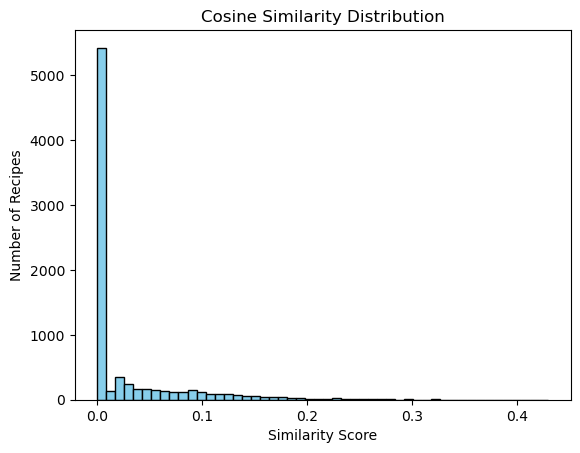

In [82]:
user_query = "healthy pasta with cheese and chicken"
user_query_tfidf = vectorizer.transform([user_query])
similarities = cosine_similarity(user_query_tfidf, tfidf_matrix).flatten()

plt.hist(similarities, bins=50, color='skyblue', edgecolor='black')
plt.title("Cosine Similarity Distribution")
plt.xlabel("Similarity Score")
plt.ylabel("Number of Recipes")
plt.show()


**2D**

In [84]:
# Reduce TF-IDF to 2D
pca = PCA(n_components=2)
reduced = pca.fit_transform(tfidf_matrix.toarray())



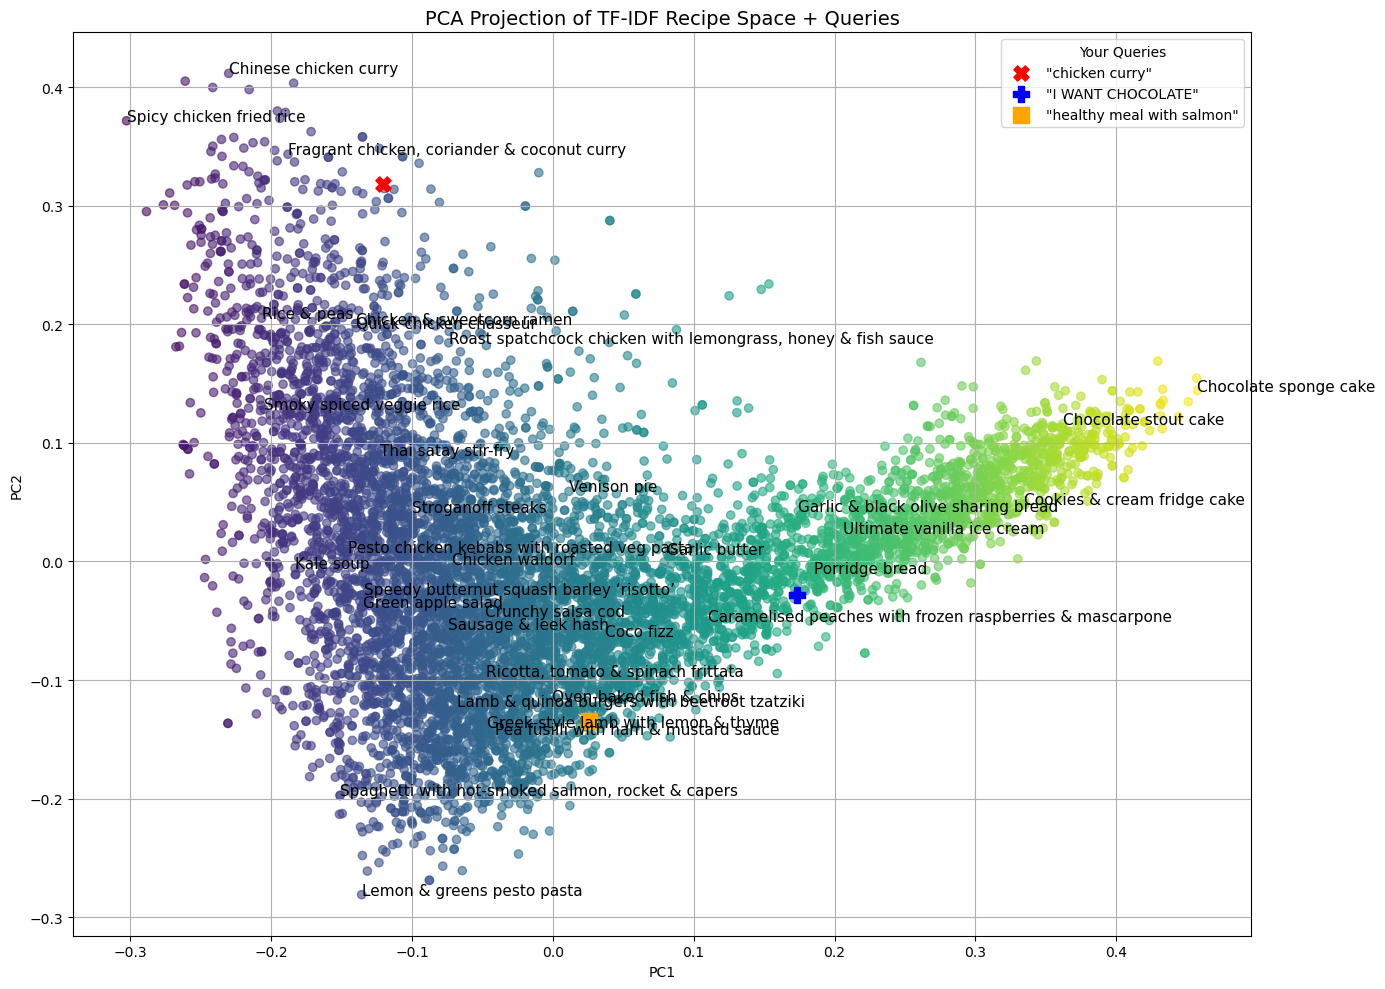

In [112]:
plt.figure(figsize=(14, 10))
plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.6, c=reduced[:, 0], cmap='viridis')

# === Label interesting points ===

# 1. Furthest right (max X)
right_idx = np.argmax(reduced[:, 0])
plt.text(reduced[right_idx, 0], reduced[right_idx, 1], recipe_df["Title"].iloc[right_idx],
         fontsize=11, color='black')

# 2. Furthest left (min X)
left_idx = np.argmin(reduced[:, 0])
plt.text(reduced[left_idx, 0], reduced[left_idx, 1], recipe_df["Title"].iloc[left_idx],
         fontsize=11, color='black')

# 3. Highest (max Y)
top_idx = np.argmax(reduced[:, 1])
plt.text(reduced[top_idx, 0], reduced[top_idx, 1], recipe_df["Title"].iloc[top_idx],
         fontsize=11, color='black')

# 4. Lowest (min Y)
bottom_idx = np.argmin(reduced[:, 1])
plt.text(reduced[bottom_idx, 0], reduced[bottom_idx, 1], recipe_df["Title"].iloc[bottom_idx],
         fontsize=11, color='black')

# 5. Random extra labels
random_idxs = np.random.choice(len(recipe_df), size=30, replace=False)
for i in random_idxs:
    plt.text(reduced[i, 0], reduced[i, 1], recipe_df["Title"].iloc[i], fontsize=11, alpha=1)

# === Plot multiple user queries ===
queries = ["chicken curry","I WANT CHOCOLATE", "healthy meal with salmon"]
colors = ['red', 'blue', 'orange']
markers = ['X', 'P', 's']

for q, color, marker in zip(queries, colors, markers):
    q_vec = vectorizer.transform([q])
    q_proj = pca.transform(q_vec.toarray())

    plt.scatter(q_proj[0, 0], q_proj[0, 1], color=color, marker=marker, s=120, label=f'"{q}"')
    #plt.text(q_proj[0, 0]+0.1, q_proj[0, 1], q, fontsize=10, color=color)

# Final touches
plt.title("PCA Projection of TF-IDF Recipe Space + Queries", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Your Queries", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


**3D PCA**

In [56]:
pca = PCA(n_components=3)
reduced_3d = pca.fit_transform(tfidf_matrix.toarray())



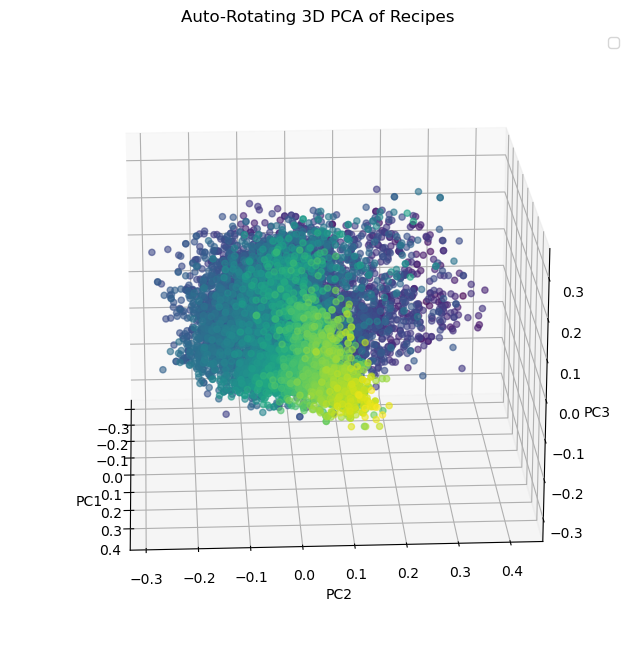

In [57]:
# Setup plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Initial scatter
sc = ax.scatter(reduced_3d[:, 0], reduced_3d[:, 1], reduced_3d[:, 2],
                c=reduced_3d[:, 0], cmap='viridis', alpha=0.6)

ax.set_title("Auto-Rotating 3D PCA of Recipes")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()

# Animate rotation
for angle in range(0, 360, 3):
    ax.view_init(elev=20, azim=angle)
    clear_output(wait=True)
    display(fig)
    plt.pause(0.01)

plt.close()


# 7. LIME TRIAL

In [587]:
import pandas as pd
import numpy as np
import ollama
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from lime.lime_text import LimeTextExplainer

In [571]:
recipe_df.columns

Index(['Title', 'Prep Time (mins)', 'Cook Time (mins)', 'Servings',
       'Ingredients', 'Method', 'Calories (g)', 'Fat (g)', 'Carbs (g)',
       'Protein (g)', 'Total Time (mins)', 'Searchable_Text', 'cleaned_text',
       'tokens', 'sentences', 'filtered_tokens', 'stemmed', 'lemmatized',
       'sentence_length', 'token_count', 'Similarity', 'Embeddings',
       'Recipe_Embeddings'],
      dtype='object')

In [592]:
# !ollama pull mistral

python(5602) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest 
pulling ff82381e2bea... 100% ▕████████████████▏ 4.1 GB                         
pulling 43070e2d4e53... 100% ▕████████████████▏  11 KB                         
pulling 491dfa501e59... 100% ▕████████████████▏  801 B                         
pulling ed11eda7790d... 100% ▕████████████████▏   30 B                         
pulling 42347cd80dc8... 100% ▕████████████████▏  485 B                         
verifying sha256 digest 
writing manifest 
success 


In [99]:
# import ollama

# # Custom dataset: a knowledge base for the chatbot
# faq_data = {
#     "What is Ollama?": "Ollama is an AI model for local inference.",
#     "How can I use Ollama for NLP?": "You can use it for classification, summarization, and chatbots.",
#     "Is Ollama cloud-based?": "No, it runs locally on your machine."
# }

# # Chatbot loop with dataset retrieval
# print("Welcome to the AI Chatbot! Type 'exit' to end.")

# while True:
#     user_input = input("You: ")

#     if user_input.lower() == 'exit':
#         print("Chatbot: Goodbye!")
#         break

#     # Use predefined dataset if input matches exactly
#     if user_input in faq_data:
#         print("Chatbot:", faq_data[user_input])
#     else:
#         # Query Ollama if no exact match in FAQ
#         response = ollama.chat(model="mistral", messages=[{"role": "user", "content": user_input}])
#         print("Chatbot:", response['message']['content'])


In [101]:
# # Function to get chatbot response using Ollama
# def chatbot_response(text):
#  response = ollama.chat(model="mistral", messages=[{"role": "user",
# "content": text}])
#  return response['message']['content']

# # Explain chatbot response

# sample_input = "Tell me about AI ethics."
# exp = explainer.explain_instance(sample_input, chatbot_response,
# num_features=10)
# exp.show_in_notebook(text=True)

I attempted to implement LIME on the model using Minstrel, but was unsuccessful. With more time and as part of future work, this would be an interesting direction to explore further.

### Future Work

- Investigate the use of the full BERT model.
- Exclude instructional content (e.g., step-by-step cooking instructions) from training data to reduce noise and improve model focus.
- Explore alternative embedding techniques such as Word2Vec to enhance semantic understanding of recipe-related inputs.
- Experiment with convolutional neural networks (CNNs) to capture local dependencies in user queries for improved intent classification.
- Revisit LIME or similar explainability tools to provide transparent insights into model decision-making processes.
